# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

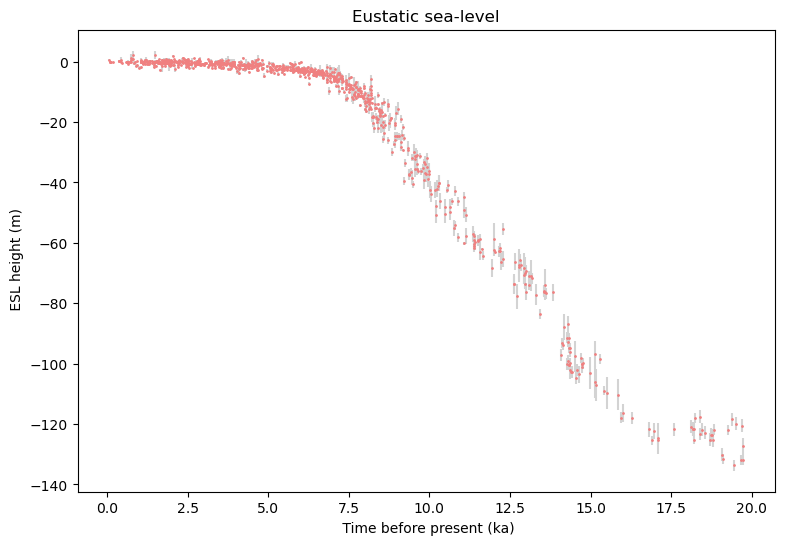

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

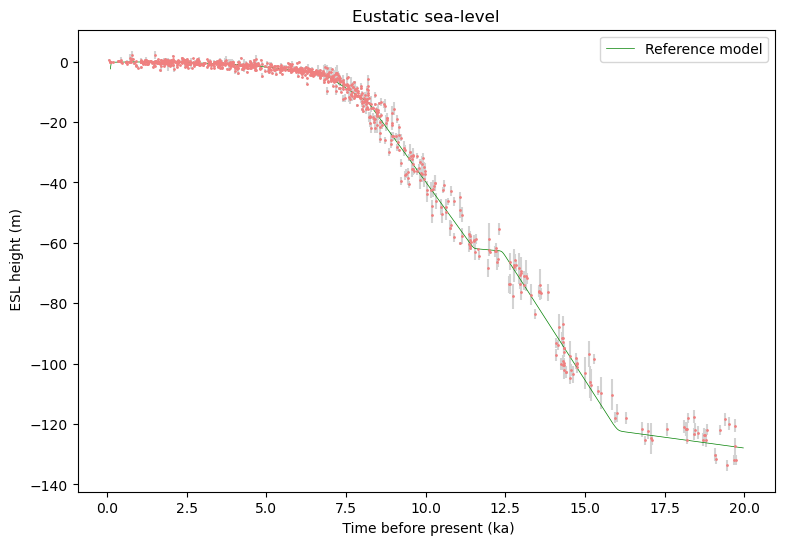

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'sampling', 'optimization', 'matrix solvers'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim",
        "cofi.border_collie_optimization"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee",
        "bayesbay"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

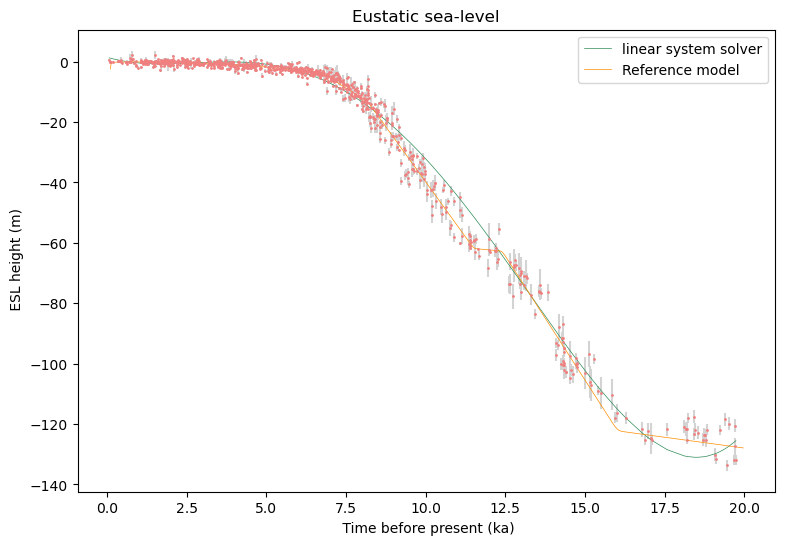

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]

Summary for inversion result
SUCCESS
----------------------------
fun: 310.0689929995378
nit: 560
nfev: 916
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[-0.81319113, -0.46081553,  0.61740809, -0.12663625,  0.00398136],
       [-0.81328903, -0.46081801,  0.61741429, -0.1266371 ,  0.0039814 ],
       [-0.81317886, -0.46081571,  0.61738786, -0.12663294,  0.00398125],
       [-0.81315239, -0.46081502,  0.61739705, -0.12663469,  0.0039813 ],
       [-0.81320724, -0.46081746,  0.61741117, -0.12663795,  0.00398147],
       [-0.81318091, -0.4608153 ,  0.61740441, -0.12663565,  0.00398136]]), array([310.068993  , 310.06899312, 310.0689937 , 310.06899379,
       310.06899388, 310.06899454]))
model: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]


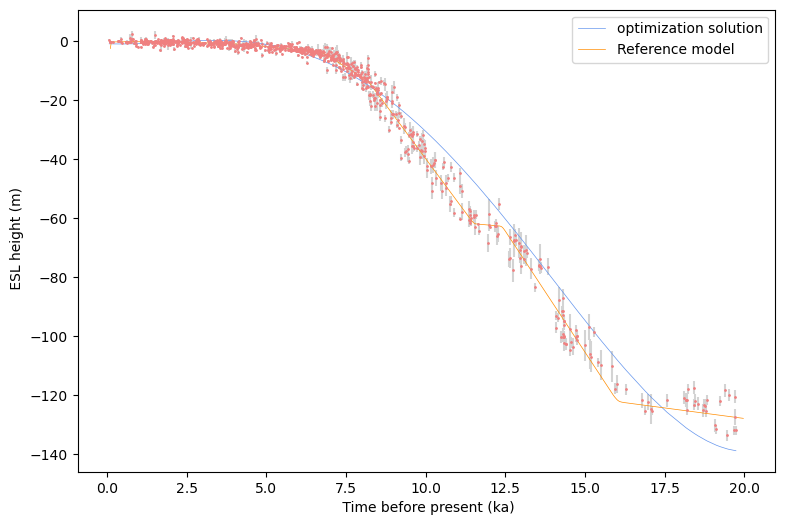

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


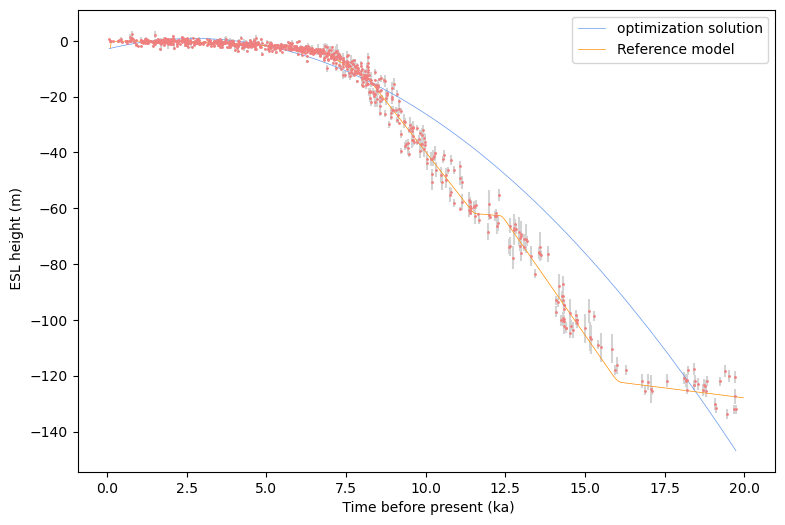

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                                                            | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                 | 18/10000 [00:00<00:57, 174.43it/s]

  0%|▌                                                                                                                                                                 | 36/10000 [00:00<00:56, 176.44it/s]

  1%|▊                                                                                                                                                                 | 54/10000 [00:00<00:59, 166.85it/s]

  1%|█▏                                                                                                                                                                | 72/10000 [00:00<00:58, 171.08it/s]

  1%|█▌                                                                                                                                                                | 94/10000 [00:00<00:55, 179.61it/s]

  1%|█▊                                                                                                                                                               | 113/10000 [00:00<00:54, 180.67it/s]

  1%|██▏                                                                                                                                                              | 132/10000 [00:00<00:57, 172.66it/s]

  2%|██▍                                                                                                                                                              | 150/10000 [00:00<00:56, 174.30it/s]

  2%|██▋                                                                                                                                                              | 168/10000 [00:00<00:55, 175.71it/s]

  2%|██▉                                                                                                                                                              | 186/10000 [00:01<00:55, 176.64it/s]

  2%|███▎                                                                                                                                                             | 204/10000 [00:01<00:59, 163.74it/s]

  2%|███▌                                                                                                                                                             | 221/10000 [00:01<01:02, 156.51it/s]

  2%|███▊                                                                                                                                                             | 239/10000 [00:01<01:00, 162.05it/s]

  3%|████                                                                                                                                                             | 256/10000 [00:01<01:01, 157.88it/s]

  3%|████▍                                                                                                                                                            | 274/10000 [00:01<00:59, 163.09it/s]

  3%|████▋                                                                                                                                                            | 291/10000 [00:01<01:10, 138.55it/s]

  3%|█████                                                                                                                                                            | 312/10000 [00:01<01:01, 156.35it/s]

  3%|█████▎                                                                                                                                                           | 332/10000 [00:01<00:57, 166.82it/s]

  4%|█████▋                                                                                                                                                           | 350/10000 [00:02<00:57, 168.90it/s]

  4%|█████▉                                                                                                                                                           | 368/10000 [00:02<01:00, 159.97it/s]

  4%|██████▍                                                                                                                                                          | 396/10000 [00:02<00:52, 184.31it/s]

  4%|██████▋                                                                                                                                                          | 415/10000 [00:02<00:54, 176.15it/s]

  4%|██████▉                                                                                                                                                          | 433/10000 [00:02<00:58, 164.55it/s]

  5%|███████▍                                                                                                                                                         | 459/10000 [00:02<00:50, 189.12it/s]

  5%|███████▋                                                                                                                                                         | 479/10000 [00:02<00:57, 166.78it/s]

  5%|████████                                                                                                                                                         | 497/10000 [00:02<00:59, 160.36it/s]

  5%|████████▍                                                                                                                                                        | 523/10000 [00:03<00:51, 184.31it/s]

  5%|████████▋                                                                                                                                                        | 543/10000 [00:03<00:59, 159.77it/s]

  6%|█████████                                                                                                                                                        | 566/10000 [00:03<00:53, 176.19it/s]

  6%|█████████▍                                                                                                                                                       | 585/10000 [00:03<00:54, 171.28it/s]

  6%|█████████▋                                                                                                                                                       | 603/10000 [00:03<00:56, 166.01it/s]

  6%|█████████▉                                                                                                                                                       | 621/10000 [00:03<00:57, 162.41it/s]

  6%|██████████▎                                                                                                                                                      | 641/10000 [00:03<00:54, 171.35it/s]

  7%|██████████▋                                                                                                                                                      | 662/10000 [00:03<00:52, 177.24it/s]

  7%|██████████▉                                                                                                                                                      | 680/10000 [00:04<00:53, 175.82it/s]

  7%|███████████▏                                                                                                                                                     | 698/10000 [00:04<00:52, 176.09it/s]

  7%|███████████▌                                                                                                                                                     | 716/10000 [00:04<01:01, 149.92it/s]

  7%|███████████▊                                                                                                                                                     | 733/10000 [00:04<01:01, 149.83it/s]

  8%|████████████                                                                                                                                                     | 751/10000 [00:04<00:58, 156.88it/s]

  8%|████████████▍                                                                                                                                                    | 773/10000 [00:04<00:53, 172.93it/s]

  8%|████████████▋                                                                                                                                                    | 791/10000 [00:04<00:55, 167.29it/s]

  8%|█████████████                                                                                                                                                    | 809/10000 [00:04<00:56, 161.90it/s]

  8%|█████████████▎                                                                                                                                                   | 826/10000 [00:04<00:59, 153.50it/s]

  8%|█████████████▌                                                                                                                                                   | 842/10000 [00:05<01:01, 147.81it/s]

  9%|█████████████▊                                                                                                                                                   | 858/10000 [00:05<01:03, 144.88it/s]

  9%|██████████████                                                                                                                                                   | 875/10000 [00:05<01:01, 149.33it/s]

  9%|██████████████▎                                                                                                                                                  | 891/10000 [00:05<01:06, 137.44it/s]

  9%|██████████████▋                                                                                                                                                  | 910/10000 [00:05<01:01, 148.91it/s]

  9%|██████████████▉                                                                                                                                                  | 926/10000 [00:05<01:03, 144.01it/s]

  9%|███████████████▏                                                                                                                                                 | 941/10000 [00:05<01:08, 131.93it/s]

 10%|███████████████▍                                                                                                                                                 | 957/10000 [00:05<01:05, 138.55it/s]

 10%|███████████████▋                                                                                                                                                 | 972/10000 [00:06<01:14, 120.90it/s]

 10%|███████████████▉                                                                                                                                                 | 990/10000 [00:06<01:06, 134.50it/s]

 10%|████████████████                                                                                                                                                | 1005/10000 [00:06<01:06, 135.39it/s]

 10%|████████████████▍                                                                                                                                               | 1024/10000 [00:06<01:00, 148.07it/s]

 10%|████████████████▋                                                                                                                                               | 1040/10000 [00:06<01:05, 137.48it/s]

 11%|████████████████▉                                                                                                                                               | 1055/10000 [00:06<01:06, 134.45it/s]

 11%|█████████████████▏                                                                                                                                              | 1072/10000 [00:06<01:02, 142.41it/s]

 11%|█████████████████▍                                                                                                                                              | 1088/10000 [00:06<01:02, 143.02it/s]

 11%|█████████████████▋                                                                                                                                              | 1106/10000 [00:06<00:59, 150.37it/s]

 11%|█████████████████▉                                                                                                                                              | 1122/10000 [00:07<01:04, 137.51it/s]

 11%|██████████████████▏                                                                                                                                             | 1140/10000 [00:07<00:59, 147.94it/s]

 12%|██████████████████▌                                                                                                                                             | 1160/10000 [00:07<00:54, 161.77it/s]

 12%|██████████████████▊                                                                                                                                             | 1177/10000 [00:07<00:55, 159.26it/s]

 12%|███████████████████                                                                                                                                             | 1195/10000 [00:07<00:54, 162.44it/s]

 12%|███████████████████▍                                                                                                                                            | 1213/10000 [00:07<00:52, 167.03it/s]

 12%|███████████████████▋                                                                                                                                            | 1230/10000 [00:07<00:53, 163.21it/s]

 12%|███████████████████▉                                                                                                                                            | 1249/10000 [00:07<00:51, 169.93it/s]

 13%|████████████████████▍                                                                                                                                           | 1280/10000 [00:07<00:41, 209.87it/s]

 13%|████████████████████▊                                                                                                                                           | 1302/10000 [00:08<00:45, 192.62it/s]

 13%|█████████████████████▏                                                                                                                                          | 1322/10000 [00:08<00:47, 184.36it/s]

 13%|█████████████████████▍                                                                                                                                          | 1341/10000 [00:08<00:50, 170.24it/s]

 14%|█████████████████████▊                                                                                                                                          | 1366/10000 [00:08<00:45, 189.81it/s]

 14%|██████████████████████▎                                                                                                                                         | 1393/10000 [00:08<00:42, 204.13it/s]

 14%|██████████████████████▌                                                                                                                                         | 1414/10000 [00:08<00:46, 185.09it/s]

 14%|██████████████████████▉                                                                                                                                         | 1434/10000 [00:08<00:49, 171.60it/s]

 15%|███████████████████████▏                                                                                                                                        | 1452/10000 [00:08<00:57, 149.73it/s]

 15%|███████████████████████▍                                                                                                                                        | 1468/10000 [00:09<01:03, 134.11it/s]

 15%|███████████████████████▊                                                                                                                                        | 1485/10000 [00:09<01:00, 141.74it/s]

 15%|████████████████████████                                                                                                                                        | 1500/10000 [00:09<01:04, 132.15it/s]

 15%|████████████████████████▏                                                                                                                                       | 1514/10000 [00:09<01:06, 128.26it/s]

 15%|████████████████████████▌                                                                                                                                       | 1536/10000 [00:09<00:57, 146.10it/s]

 16%|████████████████████████▊                                                                                                                                       | 1551/10000 [00:09<01:00, 138.72it/s]

 16%|█████████████████████████                                                                                                                                       | 1566/10000 [00:09<01:00, 139.06it/s]

 16%|█████████████████████████▎                                                                                                                                      | 1581/10000 [00:09<01:03, 131.99it/s]

 16%|█████████████████████████▌                                                                                                                                      | 1595/10000 [00:10<01:10, 119.51it/s]

 16%|█████████████████████████▋                                                                                                                                      | 1608/10000 [00:10<01:11, 117.05it/s]

 16%|██████████████████████████                                                                                                                                      | 1626/10000 [00:10<01:03, 132.24it/s]

 16%|██████████████████████████▏                                                                                                                                     | 1640/10000 [00:10<01:02, 132.76it/s]

 17%|██████████████████████████▌                                                                                                                                     | 1658/10000 [00:10<00:57, 145.03it/s]

 17%|██████████████████████████▊                                                                                                                                     | 1674/10000 [00:10<00:55, 149.12it/s]

 17%|███████████████████████████                                                                                                                                     | 1690/10000 [00:10<01:04, 128.08it/s]

 17%|███████████████████████████▍                                                                                                                                    | 1712/10000 [00:10<00:55, 149.40it/s]

 17%|███████████████████████████▋                                                                                                                                    | 1728/10000 [00:11<00:55, 149.53it/s]

 17%|███████████████████████████▉                                                                                                                                    | 1749/10000 [00:11<00:49, 165.05it/s]

 18%|████████████████████████████▎                                                                                                                                   | 1767/10000 [00:11<00:54, 150.65it/s]

 18%|████████████████████████████▌                                                                                                                                   | 1783/10000 [00:11<00:55, 148.92it/s]

 18%|████████████████████████████▊                                                                                                                                   | 1800/10000 [00:11<00:53, 153.86it/s]

 18%|█████████████████████████████                                                                                                                                   | 1816/10000 [00:11<00:58, 140.96it/s]

 18%|█████████████████████████████▎                                                                                                                                  | 1832/10000 [00:11<00:58, 140.33it/s]

 18%|█████████████████████████████▌                                                                                                                                  | 1847/10000 [00:11<00:59, 136.16it/s]

 19%|█████████████████████████████▊                                                                                                                                  | 1861/10000 [00:11<01:03, 128.13it/s]

 19%|██████████████████████████████                                                                                                                                  | 1882/10000 [00:12<00:55, 145.51it/s]

 19%|██████████████████████████████▎                                                                                                                                 | 1897/10000 [00:12<00:56, 143.12it/s]

 19%|██████████████████████████████▋                                                                                                                                 | 1915/10000 [00:12<00:53, 152.08it/s]

 19%|██████████████████████████████▉                                                                                                                                 | 1931/10000 [00:12<00:53, 150.38it/s]

 19%|███████████████████████████████▏                                                                                                                                | 1947/10000 [00:12<00:54, 147.45it/s]

 20%|███████████████████████████████▍                                                                                                                                | 1962/10000 [00:12<01:00, 133.71it/s]

 20%|███████████████████████████████▋                                                                                                                                | 1978/10000 [00:12<00:58, 136.64it/s]

 20%|███████████████████████████████▉                                                                                                                                | 1995/10000 [00:12<00:55, 144.29it/s]

 20%|████████████████████████████████▏                                                                                                                               | 2015/10000 [00:12<00:50, 158.45it/s]

 20%|████████████████████████████████▌                                                                                                                               | 2033/10000 [00:13<00:48, 163.43it/s]

 21%|████████████████████████████████▊                                                                                                                               | 2051/10000 [00:13<00:49, 160.14it/s]

 21%|█████████████████████████████████                                                                                                                               | 2068/10000 [00:13<00:52, 150.23it/s]

 21%|█████████████████████████████████▎                                                                                                                              | 2084/10000 [00:13<00:55, 142.50it/s]

 21%|█████████████████████████████████▌                                                                                                                              | 2101/10000 [00:13<00:54, 144.44it/s]

 21%|█████████████████████████████████▊                                                                                                                              | 2116/10000 [00:13<00:57, 137.20it/s]

 21%|██████████████████████████████████▎                                                                                                                             | 2147/10000 [00:13<00:43, 182.20it/s]

 22%|██████████████████████████████████▋                                                                                                                             | 2166/10000 [00:13<00:44, 176.36it/s]

 22%|██████████████████████████████████▉                                                                                                                             | 2185/10000 [00:14<00:50, 153.53it/s]

 22%|███████████████████████████████████▏                                                                                                                            | 2202/10000 [00:14<00:49, 156.38it/s]

 22%|███████████████████████████████████▌                                                                                                                            | 2219/10000 [00:14<00:53, 144.95it/s]

 22%|███████████████████████████████████▊                                                                                                                            | 2236/10000 [00:14<00:51, 150.21it/s]

 23%|████████████████████████████████████                                                                                                                            | 2252/10000 [00:14<00:53, 144.90it/s]

 23%|████████████████████████████████████▎                                                                                                                           | 2267/10000 [00:14<00:54, 142.22it/s]

 23%|████████████████████████████████████▌                                                                                                                           | 2284/10000 [00:14<00:53, 144.47it/s]

 23%|████████████████████████████████████▊                                                                                                                           | 2299/10000 [00:14<00:54, 142.54it/s]

 23%|█████████████████████████████████████                                                                                                                           | 2314/10000 [00:14<00:54, 141.59it/s]

 23%|█████████████████████████████████████▎                                                                                                                          | 2329/10000 [00:15<00:54, 140.75it/s]

 23%|█████████████████████████████████████▌                                                                                                                          | 2344/10000 [00:15<00:57, 134.21it/s]

 24%|█████████████████████████████████████▊                                                                                                                          | 2361/10000 [00:15<00:55, 138.76it/s]

 24%|██████████████████████████████████████                                                                                                                          | 2375/10000 [00:15<00:55, 136.99it/s]

 24%|██████████████████████████████████████▎                                                                                                                         | 2392/10000 [00:15<00:52, 145.01it/s]

 24%|██████████████████████████████████████▌                                                                                                                         | 2411/10000 [00:15<00:48, 157.16it/s]

 24%|██████████████████████████████████████▉                                                                                                                         | 2431/10000 [00:15<00:46, 161.28it/s]

 24%|███████████████████████████████████████▏                                                                                                                        | 2448/10000 [00:15<00:53, 141.60it/s]

 25%|███████████████████████████████████████▍                                                                                                                        | 2463/10000 [00:16<00:55, 135.51it/s]

 25%|███████████████████████████████████████▊                                                                                                                        | 2486/10000 [00:16<00:47, 159.01it/s]

 25%|████████████████████████████████████████                                                                                                                        | 2505/10000 [00:16<00:45, 165.15it/s]

 25%|████████████████████████████████████████▎                                                                                                                       | 2522/10000 [00:16<00:49, 152.20it/s]

 25%|████████████████████████████████████████▋                                                                                                                       | 2541/10000 [00:16<00:47, 158.53it/s]

 26%|████████████████████████████████████████▉                                                                                                                       | 2558/10000 [00:16<00:50, 146.06it/s]

 26%|█████████████████████████████████████████▏                                                                                                                      | 2576/10000 [00:16<00:50, 148.06it/s]

 26%|█████████████████████████████████████████▍                                                                                                                      | 2592/10000 [00:16<00:53, 139.65it/s]

 26%|█████████████████████████████████████████▊                                                                                                                      | 2610/10000 [00:16<00:49, 149.58it/s]

 26%|██████████████████████████████████████████                                                                                                                      | 2626/10000 [00:17<00:54, 134.76it/s]

 26%|██████████████████████████████████████████▏                                                                                                                     | 2640/10000 [00:17<00:54, 135.93it/s]

 27%|██████████████████████████████████████████▍                                                                                                                     | 2654/10000 [00:17<00:53, 136.52it/s]

 27%|██████████████████████████████████████████▋                                                                                                                     | 2668/10000 [00:17<00:57, 128.43it/s]

 27%|██████████████████████████████████████████▉                                                                                                                     | 2686/10000 [00:17<00:52, 139.39it/s]

 27%|███████████████████████████████████████████▍                                                                                                                    | 2713/10000 [00:17<00:41, 174.44it/s]

 27%|███████████████████████████████████████████▋                                                                                                                    | 2731/10000 [00:17<00:47, 154.62it/s]

 28%|████████████████████████████████████████████                                                                                                                    | 2751/10000 [00:17<00:43, 165.80it/s]

 28%|████████████████████████████████████████████▎                                                                                                                   | 2769/10000 [00:18<00:48, 149.99it/s]

 28%|████████████████████████████████████████████▌                                                                                                                   | 2785/10000 [00:18<00:56, 128.71it/s]

 28%|████████████████████████████████████████████▊                                                                                                                   | 2799/10000 [00:18<00:55, 128.87it/s]

 28%|█████████████████████████████████████████████                                                                                                                   | 2813/10000 [00:18<00:55, 129.15it/s]

 28%|█████████████████████████████████████████████▏                                                                                                                  | 2828/10000 [00:18<00:54, 131.39it/s]

 28%|█████████████████████████████████████████████▍                                                                                                                  | 2842/10000 [00:18<00:54, 132.14it/s]

 29%|█████████████████████████████████████████████▋                                                                                                                  | 2859/10000 [00:18<00:50, 142.24it/s]

 29%|██████████████████████████████████████████████                                                                                                                  | 2875/10000 [00:18<00:49, 144.80it/s]

 29%|██████████████████████████████████████████████▎                                                                                                                 | 2891/10000 [00:18<00:48, 147.66it/s]

 29%|██████████████████████████████████████████████▍                                                                                                                 | 2906/10000 [00:19<00:55, 127.60it/s]

 29%|██████████████████████████████████████████████▋                                                                                                                 | 2920/10000 [00:19<00:56, 125.52it/s]

 29%|███████████████████████████████████████████████                                                                                                                 | 2938/10000 [00:19<00:50, 138.93it/s]

 30%|███████████████████████████████████████████████▏                                                                                                                | 2953/10000 [00:19<00:50, 138.92it/s]

 30%|███████████████████████████████████████████████▍                                                                                                                | 2968/10000 [00:19<00:50, 138.51it/s]

 30%|███████████████████████████████████████████████▋                                                                                                                | 2983/10000 [00:19<00:52, 133.09it/s]

 30%|████████████████████████████████████████████████                                                                                                                | 3000/10000 [00:19<00:49, 142.06it/s]

 30%|████████████████████████████████████████████████▏                                                                                                               | 3015/10000 [00:19<00:48, 142.89it/s]

 30%|████████████████████████████████████████████████▌                                                                                                               | 3035/10000 [00:20<00:44, 158.01it/s]

 31%|█████████████████████████████████████████████████                                                                                                               | 3068/10000 [00:20<00:33, 205.59it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                              | 3100/10000 [00:20<00:29, 236.87it/s]

 31%|██████████████████████████████████████████████████                                                                                                              | 3132/10000 [00:20<00:26, 260.81it/s]

 32%|██████████████████████████████████████████████████▌                                                                                                             | 3164/10000 [00:20<00:24, 277.62it/s]

 32%|███████████████████████████████████████████████████▏                                                                                                            | 3196/10000 [00:20<00:23, 288.76it/s]

 32%|███████████████████████████████████████████████████▋                                                                                                            | 3228/10000 [00:20<00:22, 297.55it/s]

 33%|████████████████████████████████████████████████████▏                                                                                                           | 3260/10000 [00:20<00:22, 304.14it/s]

 33%|████████████████████████████████████████████████████▋                                                                                                           | 3292/10000 [00:20<00:21, 307.53it/s]

 33%|█████████████████████████████████████████████████████▏                                                                                                          | 3324/10000 [00:20<00:21, 310.05it/s]

 34%|█████████████████████████████████████████████████████▋                                                                                                          | 3356/10000 [00:21<00:21, 312.12it/s]

 34%|██████████████████████████████████████████████████████▏                                                                                                         | 3388/10000 [00:21<00:21, 313.91it/s]

 34%|██████████████████████████████████████████████████████▋                                                                                                         | 3420/10000 [00:21<00:20, 315.16it/s]

 35%|███████████████████████████████████████████████████████▏                                                                                                        | 3453/10000 [00:21<00:20, 316.86it/s]

 35%|███████████████████████████████████████████████████████▊                                                                                                        | 3485/10000 [00:21<00:20, 315.24it/s]

 35%|████████████████████████████████████████████████████████▎                                                                                                       | 3517/10000 [00:21<00:22, 293.34it/s]

 35%|████████████████████████████████████████████████████████▊                                                                                                       | 3549/10000 [00:21<00:21, 298.42it/s]

 36%|█████████████████████████████████████████████████████████▎                                                                                                      | 3580/10000 [00:21<00:23, 275.30it/s]

 36%|█████████████████████████████████████████████████████████▊                                                                                                      | 3612/10000 [00:21<00:22, 286.87it/s]

 36%|██████████████████████████████████████████████████████████▎                                                                                                     | 3644/10000 [00:21<00:21, 295.70it/s]

 37%|██████████████████████████████████████████████████████████▊                                                                                                     | 3676/10000 [00:22<00:21, 300.91it/s]

 37%|███████████████████████████████████████████████████████████▎                                                                                                    | 3708/10000 [00:22<00:20, 305.89it/s]

 37%|███████████████████████████████████████████████████████████▊                                                                                                    | 3740/10000 [00:22<00:20, 309.63it/s]

 38%|████████████████████████████████████████████████████████████▎                                                                                                   | 3773/10000 [00:22<00:19, 313.75it/s]

 38%|████████████████████████████████████████████████████████████▉                                                                                                   | 3806/10000 [00:22<00:19, 315.80it/s]

 38%|█████████████████████████████████████████████████████████████▍                                                                                                  | 3838/10000 [00:22<00:19, 316.89it/s]

 39%|█████████████████████████████████████████████████████████████▉                                                                                                  | 3870/10000 [00:22<00:19, 317.55it/s]

 39%|██████████████████████████████████████████████████████████████▍                                                                                                 | 3902/10000 [00:22<00:19, 316.32it/s]

 39%|██████████████████████████████████████████████████████████████▉                                                                                                 | 3934/10000 [00:22<00:19, 314.27it/s]

 40%|███████████████████████████████████████████████████████████████▍                                                                                                | 3967/10000 [00:23<00:19, 317.11it/s]

 40%|███████████████████████████████████████████████████████████████▉                                                                                                | 3999/10000 [00:23<00:18, 317.76it/s]

 40%|████████████████████████████████████████████████████████████████▌                                                                                               | 4032/10000 [00:23<00:18, 319.69it/s]

 41%|█████████████████████████████████████████████████████████████████                                                                                               | 4065/10000 [00:23<00:18, 321.01it/s]

 41%|█████████████████████████████████████████████████████████████████▌                                                                                              | 4098/10000 [00:23<00:18, 317.41it/s]

 41%|██████████████████████████████████████████████████████████████████                                                                                              | 4130/10000 [00:23<00:18, 312.31it/s]

 42%|██████████████████████████████████████████████████████████████████▌                                                                                             | 4162/10000 [00:23<00:25, 228.45it/s]

 42%|███████████████████████████████████████████████████████████████████                                                                                             | 4189/10000 [00:23<00:27, 211.05it/s]

 42%|███████████████████████████████████████████████████████████████████▍                                                                                            | 4213/10000 [00:24<00:33, 171.96it/s]

 42%|███████████████████████████████████████████████████████████████████▋                                                                                            | 4233/10000 [00:24<00:38, 149.01it/s]

 42%|████████████████████████████████████████████████████████████████████                                                                                            | 4250/10000 [00:24<00:39, 144.10it/s]

 43%|████████████████████████████████████████████████████████████████████▎                                                                                           | 4266/10000 [00:24<00:41, 139.65it/s]

 43%|████████████████████████████████████████████████████████████████████▍                                                                                           | 4281/10000 [00:24<00:42, 133.94it/s]

 43%|████████████████████████████████████████████████████████████████████▋                                                                                           | 4295/10000 [00:24<00:45, 125.64it/s]

 43%|█████████████████████████████████████████████████████████████████████                                                                                           | 4319/10000 [00:24<00:38, 148.41it/s]

 43%|█████████████████████████████████████████████████████████████████████▎                                                                                          | 4335/10000 [00:25<00:38, 148.17it/s]

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                          | 4351/10000 [00:25<00:38, 145.58it/s]

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                          | 4366/10000 [00:25<00:42, 132.51it/s]

 44%|██████████████████████████████████████████████████████████████████████                                                                                          | 4380/10000 [00:25<00:42, 132.36it/s]

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                         | 4394/10000 [00:25<00:43, 127.46it/s]

 44%|██████████████████████████████████████████████████████████████████████▌                                                                                         | 4407/10000 [00:25<00:44, 125.35it/s]

 44%|██████████████████████████████████████████████████████████████████████▊                                                                                         | 4425/10000 [00:25<00:40, 139.35it/s]

 44%|███████████████████████████████████████████████████████████████████████                                                                                         | 4440/10000 [00:25<00:39, 139.56it/s]

 45%|███████████████████████████████████████████████████████████████████████▎                                                                                        | 4455/10000 [00:26<00:44, 123.56it/s]

 45%|███████████████████████████████████████████████████████████████████████▋                                                                                        | 4477/10000 [00:26<00:37, 147.55it/s]

 45%|███████████████████████████████████████████████████████████████████████▉                                                                                        | 4493/10000 [00:26<00:38, 142.61it/s]

 45%|████████████████████████████████████████████████████████████████████████▏                                                                                       | 4508/10000 [00:26<00:38, 141.22it/s]

 45%|████████████████████████████████████████████████████████████████████████▎                                                                                       | 4523/10000 [00:26<00:40, 134.35it/s]

 45%|████████████████████████████████████████████████████████████████████████▋                                                                                       | 4542/10000 [00:26<00:37, 147.24it/s]

 46%|████████████████████████████████████████████████████████████████████████▉                                                                                       | 4561/10000 [00:26<00:34, 158.52it/s]

 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                      | 4578/10000 [00:26<00:40, 134.31it/s]

 46%|█████████████████████████████████████████████████████████████████████████▌                                                                                      | 4599/10000 [00:26<00:36, 149.45it/s]

 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                      | 4622/10000 [00:27<00:32, 167.33it/s]

 46%|██████████████████████████████████████████████████████████████████████████▏                                                                                     | 4640/10000 [00:27<00:34, 153.49it/s]

 47%|██████████████████████████████████████████████████████████████████████████▌                                                                                     | 4657/10000 [00:27<00:37, 141.22it/s]

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                     | 4672/10000 [00:27<00:37, 140.66it/s]

 47%|███████████████████████████████████████████████████████████████████████████                                                                                     | 4689/10000 [00:27<00:36, 147.26it/s]

 47%|███████████████████████████████████████████████████████████████████████████▎                                                                                    | 4705/10000 [00:27<00:36, 143.41it/s]

 47%|███████████████████████████████████████████████████████████████████████████▌                                                                                    | 4722/10000 [00:27<00:35, 148.31it/s]

 47%|███████████████████████████████████████████████████████████████████████████▊                                                                                    | 4738/10000 [00:27<00:35, 148.86it/s]

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                   | 4763/10000 [00:27<00:29, 175.44it/s]

 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                   | 4781/10000 [00:28<00:32, 162.46it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                   | 4799/10000 [00:28<00:31, 166.25it/s]

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                   | 4817/10000 [00:28<00:30, 168.98it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▍                                                                                  | 4840/10000 [00:28<00:28, 178.40it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                                  | 4858/10000 [00:28<00:30, 171.03it/s]

 49%|██████████████████████████████████████████████████████████████████████████████                                                                                  | 4876/10000 [00:28<00:29, 171.06it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▎                                                                                 | 4894/10000 [00:28<00:31, 161.86it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                 | 4913/10000 [00:28<00:30, 167.28it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▉                                                                                 | 4930/10000 [00:29<00:32, 157.44it/s]

 49%|███████████████████████████████████████████████████████████████████████████████▏                                                                                | 4946/10000 [00:29<00:37, 135.01it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▍                                                                                | 4961/10000 [00:29<00:38, 132.08it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                                | 4975/10000 [00:29<00:39, 127.31it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                                | 4988/10000 [00:29<00:41, 121.16it/s]

 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 5002/10000 [00:29<00:39, 125.58it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▎                                                                               | 5020/10000 [00:29<00:35, 139.64it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▌                                                                               | 5035/10000 [00:29<00:37, 133.18it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▊                                                                               | 5049/10000 [00:30<00:40, 122.94it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████                                                                               | 5065/10000 [00:30<00:38, 127.16it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▎                                                                              | 5081/10000 [00:30<00:36, 133.98it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                              | 5101/10000 [00:30<00:33, 148.01it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▊                                                                              | 5117/10000 [00:30<00:32, 150.81it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▏                                                                             | 5133/10000 [00:30<00:32, 150.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▍                                                                             | 5149/10000 [00:30<00:33, 143.25it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                             | 5167/10000 [00:30<00:33, 146.08it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▉                                                                             | 5182/10000 [00:30<00:34, 137.79it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▏                                                                            | 5200/10000 [00:31<00:33, 141.86it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5216/10000 [00:31<00:32, 145.90it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5234/10000 [00:31<00:30, 153.91it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████                                                                            | 5254/10000 [00:31<00:28, 165.47it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5271/10000 [00:31<00:29, 160.26it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5288/10000 [00:31<00:30, 154.53it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5304/10000 [00:31<00:30, 153.85it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5322/10000 [00:31<00:29, 159.46it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5339/10000 [00:31<00:30, 151.72it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5357/10000 [00:32<00:29, 159.20it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5374/10000 [00:32<00:29, 155.58it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5390/10000 [00:32<00:30, 151.44it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5406/10000 [00:32<00:30, 148.34it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5422/10000 [00:32<00:31, 145.44it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████                                                                         | 5445/10000 [00:32<00:27, 168.10it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5463/10000 [00:32<00:28, 158.44it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5481/10000 [00:32<00:27, 161.57it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5498/10000 [00:32<00:28, 157.66it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5514/10000 [00:33<00:28, 155.70it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5532/10000 [00:33<00:29, 153.49it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5548/10000 [00:33<00:29, 152.31it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                       | 5567/10000 [00:33<00:27, 161.02it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5584/10000 [00:33<00:27, 163.46it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5601/10000 [00:33<00:30, 145.49it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5619/10000 [00:33<00:28, 153.41it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5640/10000 [00:33<00:26, 163.34it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5657/10000 [00:33<00:30, 141.57it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5672/10000 [00:34<00:30, 140.77it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5693/10000 [00:34<00:28, 153.68it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5709/10000 [00:34<00:29, 144.67it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5726/10000 [00:34<00:28, 149.59it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5742/10000 [00:34<00:30, 138.71it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5760/10000 [00:34<00:28, 148.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5779/10000 [00:34<00:26, 158.96it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5796/10000 [00:34<00:28, 147.73it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5816/10000 [00:35<00:26, 160.73it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5834/10000 [00:35<00:26, 158.22it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5851/10000 [00:35<00:27, 152.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5867/10000 [00:35<00:29, 140.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5882/10000 [00:35<00:30, 134.54it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5896/10000 [00:35<00:30, 133.79it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5915/10000 [00:35<00:28, 145.72it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5930/10000 [00:35<00:29, 137.75it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 5945/10000 [00:35<00:29, 138.14it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5963/10000 [00:36<00:27, 148.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5979/10000 [00:36<00:27, 145.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5994/10000 [00:36<00:29, 137.52it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 6014/10000 [00:36<00:26, 151.38it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6030/10000 [00:36<00:26, 150.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 6046/10000 [00:36<00:26, 147.30it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 6061/10000 [00:36<00:28, 137.03it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6081/10000 [00:36<00:25, 153.09it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 6098/10000 [00:36<00:25, 154.96it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 6117/10000 [00:37<00:23, 163.15it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 6134/10000 [00:37<00:25, 151.03it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 6150/10000 [00:37<00:26, 145.07it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 6165/10000 [00:37<00:26, 144.39it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 6180/10000 [00:37<00:26, 142.84it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 6195/10000 [00:37<00:26, 141.03it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 6210/10000 [00:37<00:27, 136.61it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6232/10000 [00:37<00:23, 157.61it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6248/10000 [00:37<00:24, 152.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6264/10000 [00:38<00:24, 154.30it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6280/10000 [00:38<00:25, 146.94it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6298/10000 [00:38<00:23, 155.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6317/10000 [00:38<00:22, 162.63it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6334/10000 [00:38<00:23, 158.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6350/10000 [00:38<00:23, 154.16it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6366/10000 [00:38<00:25, 145.24it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6381/10000 [00:38<00:28, 126.76it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6395/10000 [00:39<00:27, 129.68it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6415/10000 [00:39<00:25, 143.23it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6447/10000 [00:39<00:18, 189.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6479/10000 [00:39<00:15, 224.19it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6511/10000 [00:39<00:13, 250.58it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6544/10000 [00:39<00:12, 271.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6577/10000 [00:39<00:11, 286.74it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6610/10000 [00:39<00:11, 297.25it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6643/10000 [00:39<00:11, 304.18it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6674/10000 [00:39<00:10, 302.66it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6706/10000 [00:40<00:10, 307.24it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6739/10000 [00:40<00:10, 311.36it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6771/10000 [00:40<00:10, 304.90it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6803/10000 [00:40<00:10, 307.63it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6834/10000 [00:40<00:10, 307.61it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6865/10000 [00:40<00:10, 303.15it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6898/10000 [00:40<00:10, 308.34it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6931/10000 [00:40<00:09, 312.25it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6964/10000 [00:40<00:09, 315.04it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6996/10000 [00:41<00:11, 260.77it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 7024/10000 [00:41<00:13, 213.44it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 7048/10000 [00:41<00:15, 190.40it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 7069/10000 [00:41<00:15, 183.59it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 7089/10000 [00:41<00:16, 177.62it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 7109/10000 [00:41<00:15, 181.94it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 7128/10000 [00:41<00:17, 164.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 7146/10000 [00:42<00:18, 150.48it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7164/10000 [00:42<00:18, 156.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 7181/10000 [00:42<00:17, 157.71it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 7205/10000 [00:42<00:15, 178.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7224/10000 [00:42<00:15, 180.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7243/10000 [00:42<00:18, 152.58it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7260/10000 [00:42<00:19, 142.28it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7276/10000 [00:42<00:18, 146.08it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7292/10000 [00:43<00:18, 147.20it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7308/10000 [00:43<00:19, 134.74it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7323/10000 [00:43<00:19, 135.45it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7337/10000 [00:43<00:20, 132.58it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7352/10000 [00:43<00:19, 135.77it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7366/10000 [00:43<00:19, 134.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7380/10000 [00:43<00:19, 134.46it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7398/10000 [00:43<00:17, 146.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7413/10000 [00:43<00:17, 144.09it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7428/10000 [00:44<00:19, 131.52it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7444/10000 [00:44<00:18, 134.64it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7458/10000 [00:44<00:22, 114.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7473/10000 [00:44<00:20, 122.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7490/10000 [00:44<00:18, 134.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7505/10000 [00:44<00:18, 135.20it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7519/10000 [00:44<00:19, 128.98it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7535/10000 [00:44<00:18, 133.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7549/10000 [00:44<00:19, 128.36it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7570/10000 [00:45<00:16, 150.31it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7586/10000 [00:45<00:15, 151.44it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7604/10000 [00:45<00:15, 152.29it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7620/10000 [00:45<00:16, 144.00it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7635/10000 [00:45<00:17, 136.84it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7650/10000 [00:45<00:17, 136.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7664/10000 [00:45<00:17, 133.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7683/10000 [00:45<00:15, 149.04it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7699/10000 [00:45<00:15, 151.41it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7715/10000 [00:46<00:15, 145.05it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7730/10000 [00:46<00:17, 127.11it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7746/10000 [00:46<00:16, 134.50it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7760/10000 [00:46<00:17, 129.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7783/10000 [00:46<00:14, 155.73it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7800/10000 [00:46<00:14, 153.65it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7816/10000 [00:46<00:15, 142.72it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7831/10000 [00:46<00:15, 143.09it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7849/10000 [00:47<00:14, 151.97it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7865/10000 [00:47<00:14, 142.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7880/10000 [00:47<00:14, 141.67it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7895/10000 [00:47<00:15, 135.39it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7910/10000 [00:47<00:15, 136.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7927/10000 [00:47<00:14, 142.29it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7945/10000 [00:47<00:13, 151.58it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7962/10000 [00:47<00:13, 156.24it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7980/10000 [00:47<00:12, 162.11it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7997/10000 [00:48<00:12, 157.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8020/10000 [00:48<00:11, 177.08it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8039/10000 [00:48<00:10, 179.24it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8058/10000 [00:48<00:12, 151.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8075/10000 [00:48<00:12, 154.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8093/10000 [00:48<00:11, 160.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8110/10000 [00:48<00:11, 158.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8127/10000 [00:48<00:12, 155.67it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8143/10000 [00:48<00:12, 149.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8162/10000 [00:49<00:11, 158.64it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8179/10000 [00:49<00:12, 145.94it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8194/10000 [00:49<00:12, 143.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8212/10000 [00:49<00:11, 151.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8228/10000 [00:49<00:12, 145.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8246/10000 [00:49<00:11, 154.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8262/10000 [00:49<00:12, 142.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8277/10000 [00:49<00:12, 137.49it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8295/10000 [00:49<00:11, 148.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8311/10000 [00:50<00:11, 146.88it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8326/10000 [00:50<00:11, 144.17it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8342/10000 [00:50<00:11, 144.42it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8357/10000 [00:50<00:11, 138.02it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8373/10000 [00:50<00:11, 142.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8395/10000 [00:50<00:09, 163.46it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8412/10000 [00:50<00:09, 159.27it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8429/10000 [00:50<00:10, 150.20it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8447/10000 [00:50<00:09, 158.04it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8464/10000 [00:51<00:09, 155.58it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8481/10000 [00:51<00:09, 159.44it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8498/10000 [00:51<00:10, 149.48it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8516/10000 [00:51<00:09, 157.00it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8532/10000 [00:51<00:09, 157.44it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8553/10000 [00:51<00:08, 170.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8571/10000 [00:51<00:09, 158.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8591/10000 [00:51<00:08, 166.00it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8608/10000 [00:51<00:08, 159.03it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8625/10000 [00:52<00:08, 158.10it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8643/10000 [00:52<00:08, 157.32it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8663/10000 [00:52<00:08, 164.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8681/10000 [00:52<00:07, 167.59it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8699/10000 [00:52<00:07, 170.00it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8717/10000 [00:52<00:08, 144.29it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8733/10000 [00:52<00:09, 140.26it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8748/10000 [00:52<00:09, 132.92it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8770/10000 [00:53<00:07, 154.46it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8787/10000 [00:53<00:08, 146.90it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8803/10000 [00:53<00:09, 131.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8818/10000 [00:53<00:08, 133.44it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8841/10000 [00:53<00:07, 157.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8858/10000 [00:53<00:07, 146.61it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8874/10000 [00:53<00:07, 147.36it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8890/10000 [00:53<00:07, 148.20it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8912/10000 [00:53<00:06, 167.68it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8930/10000 [00:54<00:06, 156.99it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8947/10000 [00:54<00:06, 154.63it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8963/10000 [00:54<00:08, 124.64it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8977/10000 [00:54<00:08, 126.34it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8995/10000 [00:54<00:07, 138.91it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9013/10000 [00:54<00:06, 148.58it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9029/10000 [00:54<00:06, 149.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9045/10000 [00:55<00:08, 118.95it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9059/10000 [00:55<00:07, 121.97it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9073/10000 [00:55<00:07, 123.45it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9088/10000 [00:55<00:07, 130.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9111/10000 [00:55<00:05, 156.24it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9128/10000 [00:55<00:05, 154.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9144/10000 [00:55<00:06, 135.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9167/10000 [00:55<00:05, 156.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9184/10000 [00:55<00:05, 152.25it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9200/10000 [00:56<00:05, 152.13it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9223/10000 [00:56<00:04, 171.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9243/10000 [00:56<00:04, 174.73it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9261/10000 [00:56<00:04, 175.63it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9279/10000 [00:56<00:04, 165.24it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9296/10000 [00:56<00:04, 159.32it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9313/10000 [00:56<00:04, 148.05it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9329/10000 [00:56<00:04, 148.73it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9347/10000 [00:56<00:04, 155.98it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9363/10000 [00:57<00:04, 152.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9384/10000 [00:57<00:03, 160.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9401/10000 [00:57<00:04, 136.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9418/10000 [00:57<00:04, 144.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9434/10000 [00:57<00:04, 133.60it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9448/10000 [00:57<00:04, 131.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9462/10000 [00:57<00:04, 127.79it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9479/10000 [00:57<00:03, 134.29it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9493/10000 [00:58<00:03, 132.32it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9512/10000 [00:58<00:03, 146.93it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9527/10000 [00:58<00:03, 147.44it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9542/10000 [00:58<00:03, 140.39it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9557/10000 [00:58<00:03, 138.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9571/10000 [00:58<00:03, 133.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9585/10000 [00:58<00:03, 127.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9601/10000 [00:58<00:03, 132.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9616/10000 [00:58<00:02, 134.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9630/10000 [00:59<00:02, 133.99it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9647/10000 [00:59<00:02, 143.60it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9666/10000 [00:59<00:02, 156.29it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9682/10000 [00:59<00:02, 150.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9699/10000 [00:59<00:01, 152.31it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9717/10000 [00:59<00:01, 159.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9733/10000 [00:59<00:01, 147.93it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9754/10000 [00:59<00:01, 160.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9771/10000 [00:59<00:01, 155.66it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9787/10000 [01:00<00:01, 128.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9805/10000 [01:00<00:01, 139.71it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9822/10000 [01:00<00:01, 147.17it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9838/10000 [01:00<00:01, 150.21it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9856/10000 [01:00<00:00, 158.00it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9877/10000 [01:00<00:00, 166.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9894/10000 [01:00<00:00, 161.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9911/10000 [01:00<00:00, 151.12it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9927/10000 [01:01<00:00, 137.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9944/10000 [01:01<00:00, 145.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9964/10000 [01:01<00:00, 156.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9989/10000 [01:01<00:00, 178.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.85it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 -0.000445 -0.0005121 ... 1.485 1.468
    m1       (chain, draw) float64 -5.55e-05 -7.86e-05 ... -3.36 -3.333
    m2       (chain, draw) float64 3.544e-05 3.385e-05 5.677e-05 ... 1.51 1.502
    m3       (chain, draw) float64 0.0002465 0.0002618 ... -0.2215 -0.2207
    m4       (chain, draw) float64 -0.0003796 -0.0004481 ... 0.007014 0.006987
Attributes:
    created_at:                 2024-02-11T23:30:13.786253
    arviz_version:              0.17.0
    inference_library:          emcee
    inference_library_version:  3.1.4

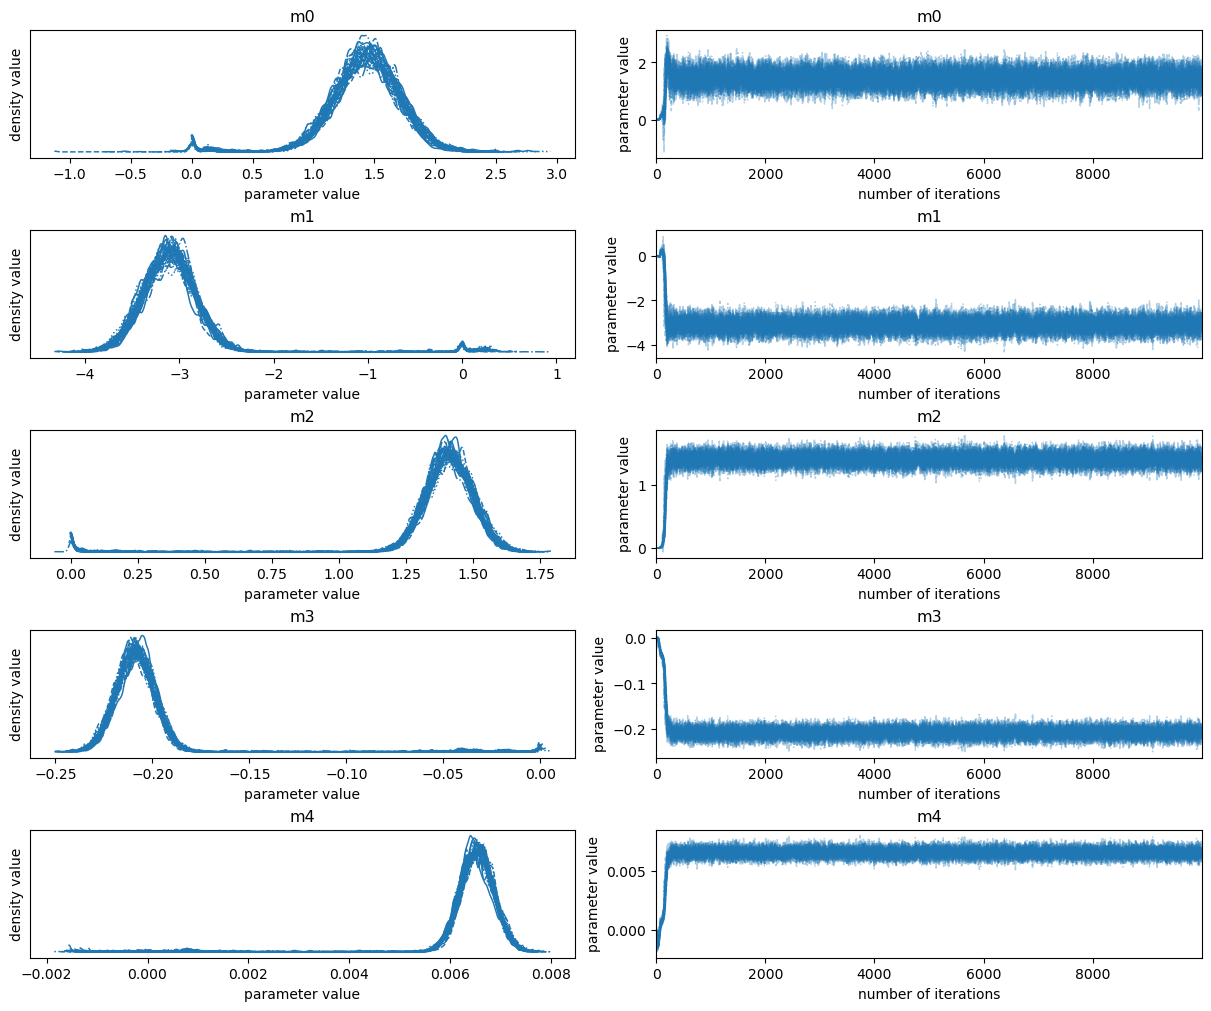

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


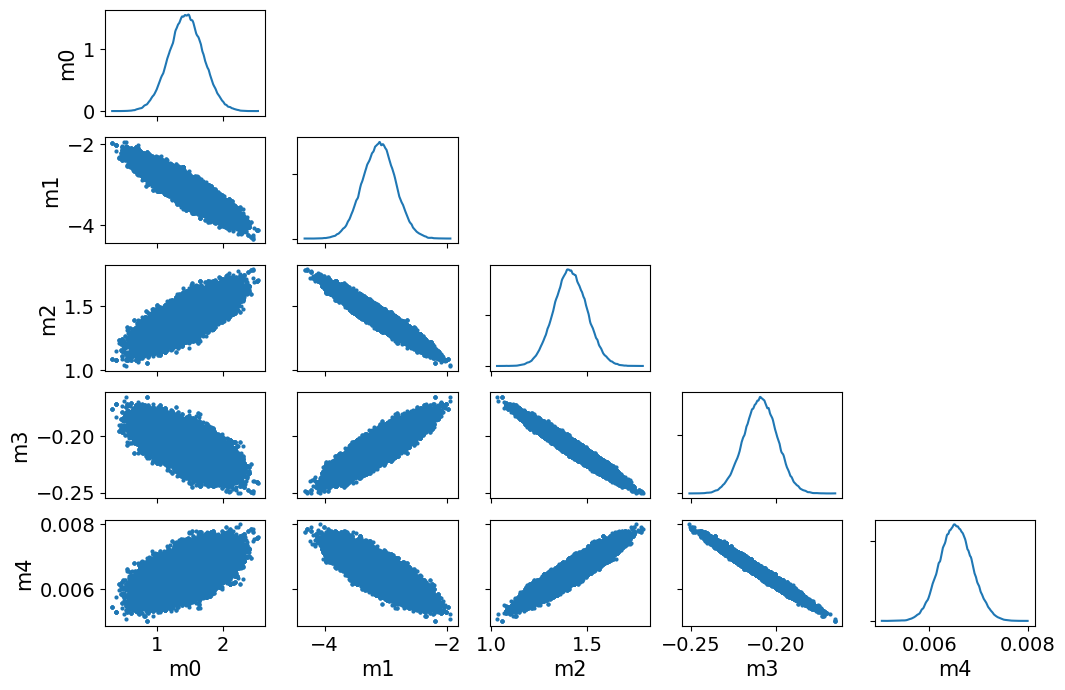

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

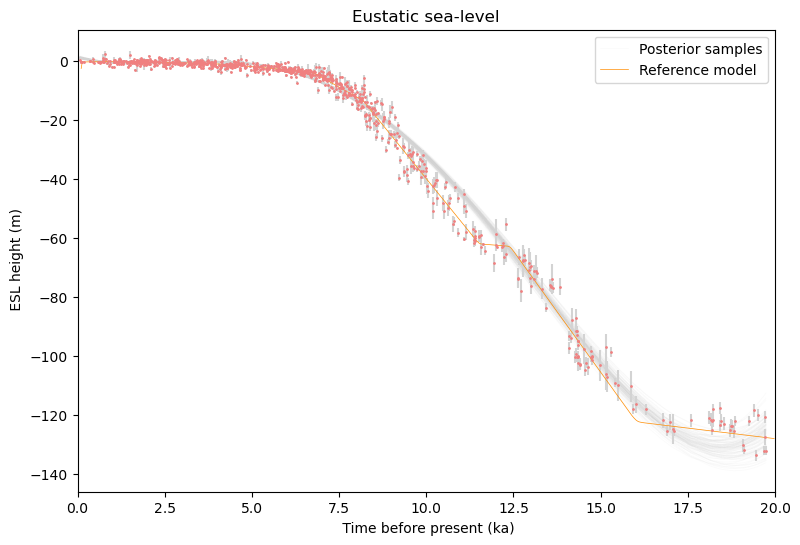

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.442 [  1.016,   1.871]
 m1  -3.111 [ -3.568,  -2.672]
 m2   1.412 [  1.273,   1.556]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.63421889e-02 -6.22470592e-02  1.66439848e-02 -1.60745754e-03
   4.78297001e-05]
 [-6.22470592e-02  7.39166261e-02 -2.23027334e-02  2.32373841e-03
  -7.22144492e-05]
 [ 1.66439848e-02 -2.23027334e-02  7.39576868e-03 -8.24611132e-04
   2.66759489e-05]
 [-1.60745754e-03  2.32373841e-03 -8.24611132e-04  9.70240182e-05
  -3.24554881e-06]
 [ 4.78297001e-05 -7.22144492e-05  2.66759489e-05 -3.24554881e-06
   1.11438149e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2576
    m1  0.2719
    m2  0.0860
    m3  0.0098
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                                                            | 0/10000 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                                 | 31/10000 [00:00<00:32, 308.06it/s]

  1%|█                                                                                                                                                                 | 62/10000 [00:00<00:47, 207.31it/s]

  1%|█▍                                                                                                                                                                | 85/10000 [00:00<00:53, 184.56it/s]

  1%|█▋                                                                                                                                                               | 105/10000 [00:00<00:55, 177.67it/s]

  1%|██                                                                                                                                                               | 126/10000 [00:00<00:54, 182.34it/s]

  1%|██▎                                                                                                                                                              | 145/10000 [00:00<00:58, 168.06it/s]

  2%|██▌                                                                                                                                                              | 163/10000 [00:00<01:02, 158.27it/s]

  2%|██▉                                                                                                                                                              | 182/10000 [00:01<00:59, 163.97it/s]

  2%|███▏                                                                                                                                                             | 199/10000 [00:01<01:01, 160.20it/s]

  2%|███▍                                                                                                                                                             | 216/10000 [00:01<01:01, 159.95it/s]

  2%|███▊                                                                                                                                                             | 234/10000 [00:01<00:59, 165.43it/s]

  3%|████                                                                                                                                                             | 253/10000 [00:01<00:56, 171.66it/s]

  3%|████▎                                                                                                                                                            | 271/10000 [00:01<01:00, 161.04it/s]

  3%|████▋                                                                                                                                                            | 290/10000 [00:01<00:57, 167.45it/s]

  3%|████▉                                                                                                                                                            | 307/10000 [00:01<01:00, 160.05it/s]

  3%|█████▎                                                                                                                                                           | 327/10000 [00:01<00:56, 171.06it/s]

  3%|█████▌                                                                                                                                                           | 349/10000 [00:02<00:52, 182.93it/s]

  4%|█████▉                                                                                                                                                           | 368/10000 [00:02<00:52, 183.63it/s]

  4%|██████▎                                                                                                                                                          | 389/10000 [00:02<00:50, 189.81it/s]

  4%|██████▌                                                                                                                                                          | 409/10000 [00:02<00:55, 172.02it/s]

  4%|██████▊                                                                                                                                                          | 427/10000 [00:02<00:55, 174.03it/s]

  4%|███████▏                                                                                                                                                         | 445/10000 [00:02<00:55, 173.09it/s]

  5%|███████▌                                                                                                                                                         | 469/10000 [00:02<00:49, 191.22it/s]

  5%|███████▊                                                                                                                                                         | 489/10000 [00:02<00:50, 188.57it/s]

  5%|████████▏                                                                                                                                                        | 510/10000 [00:02<00:49, 191.79it/s]

  5%|████████▌                                                                                                                                                        | 530/10000 [00:02<00:50, 186.01it/s]

  5%|████████▊                                                                                                                                                        | 549/10000 [00:03<00:52, 181.52it/s]

  6%|█████████▏                                                                                                                                                       | 568/10000 [00:03<01:02, 151.31it/s]

  6%|█████████▍                                                                                                                                                       | 584/10000 [00:03<01:02, 151.60it/s]

  6%|█████████▉                                                                                                                                                       | 615/10000 [00:03<00:48, 192.49it/s]

  6%|██████████▍                                                                                                                                                      | 650/10000 [00:03<00:39, 234.46it/s]

  7%|██████████▊                                                                                                                                                      | 675/10000 [00:03<00:43, 213.38it/s]

  7%|███████████▎                                                                                                                                                     | 699/10000 [00:03<00:42, 219.87it/s]

  7%|███████████▌                                                                                                                                                     | 722/10000 [00:03<00:47, 194.96it/s]

  7%|███████████▉                                                                                                                                                     | 743/10000 [00:04<00:46, 197.99it/s]

  8%|████████████▎                                                                                                                                                    | 764/10000 [00:04<00:48, 191.81it/s]

  8%|████████████▌                                                                                                                                                    | 784/10000 [00:04<00:51, 177.34it/s]

  8%|████████████▉                                                                                                                                                    | 803/10000 [00:04<00:54, 167.97it/s]

  8%|█████████████▏                                                                                                                                                   | 821/10000 [00:04<00:54, 167.83it/s]

  8%|█████████████▌                                                                                                                                                   | 840/10000 [00:04<00:53, 172.40it/s]

  9%|█████████████▊                                                                                                                                                   | 858/10000 [00:04<00:55, 165.12it/s]

  9%|██████████████                                                                                                                                                   | 875/10000 [00:04<00:55, 163.22it/s]

  9%|██████████████▍                                                                                                                                                  | 894/10000 [00:05<00:54, 168.19it/s]

  9%|██████████████▊                                                                                                                                                  | 917/10000 [00:05<00:49, 183.48it/s]

  9%|███████████████                                                                                                                                                  | 936/10000 [00:05<00:55, 163.62it/s]

 10%|███████████████▎                                                                                                                                                 | 953/10000 [00:05<00:55, 164.22it/s]

 10%|███████████████▋                                                                                                                                                 | 972/10000 [00:05<00:53, 169.12it/s]

 10%|███████████████▉                                                                                                                                                 | 990/10000 [00:05<00:55, 162.00it/s]

 10%|████████████████                                                                                                                                                | 1007/10000 [00:05<00:59, 152.21it/s]

 10%|████████████████▍                                                                                                                                               | 1026/10000 [00:05<00:56, 158.70it/s]

 10%|████████████████▋                                                                                                                                               | 1043/10000 [00:05<00:56, 158.05it/s]

 11%|████████████████▉                                                                                                                                               | 1062/10000 [00:06<00:55, 160.30it/s]

 11%|█████████████████▎                                                                                                                                              | 1079/10000 [00:06<00:57, 156.34it/s]

 11%|█████████████████▌                                                                                                                                              | 1095/10000 [00:06<00:59, 150.50it/s]

 11%|█████████████████▊                                                                                                                                              | 1113/10000 [00:06<00:56, 158.28it/s]

 11%|██████████████████                                                                                                                                              | 1129/10000 [00:06<00:56, 157.78it/s]

 12%|██████████████████▍                                                                                                                                             | 1150/10000 [00:06<00:52, 169.12it/s]

 12%|██████████████████▋                                                                                                                                             | 1167/10000 [00:06<00:53, 165.15it/s]

 12%|██████████████████▉                                                                                                                                             | 1184/10000 [00:06<00:56, 157.37it/s]

 12%|███████████████████▏                                                                                                                                            | 1200/10000 [00:06<01:03, 137.87it/s]

 12%|███████████████████▍                                                                                                                                            | 1215/10000 [00:07<01:08, 128.01it/s]

 12%|███████████████████▋                                                                                                                                            | 1231/10000 [00:07<01:04, 135.02it/s]

 12%|███████████████████▉                                                                                                                                            | 1248/10000 [00:07<01:01, 141.41it/s]

 13%|████████████████████▎                                                                                                                                           | 1266/10000 [00:07<00:59, 146.50it/s]

 13%|████████████████████▍                                                                                                                                           | 1281/10000 [00:07<01:04, 135.30it/s]

 13%|████████████████████▋                                                                                                                                           | 1295/10000 [00:07<01:03, 136.08it/s]

 13%|████████████████████▉                                                                                                                                           | 1309/10000 [00:07<01:06, 130.99it/s]

 13%|█████████████████████▏                                                                                                                                          | 1326/10000 [00:07<01:02, 139.66it/s]

 13%|█████████████████████▌                                                                                                                                          | 1345/10000 [00:08<00:58, 148.28it/s]

 14%|█████████████████████▊                                                                                                                                          | 1360/10000 [00:08<00:58, 147.13it/s]

 14%|██████████████████████                                                                                                                                          | 1376/10000 [00:08<00:58, 148.35it/s]

 14%|██████████████████████▍                                                                                                                                         | 1401/10000 [00:08<00:48, 177.00it/s]

 14%|██████████████████████▋                                                                                                                                         | 1419/10000 [00:08<00:52, 164.77it/s]

 14%|███████████████████████                                                                                                                                         | 1438/10000 [00:08<00:49, 171.34it/s]

 15%|███████████████████████▎                                                                                                                                        | 1456/10000 [00:08<00:50, 169.36it/s]

 15%|███████████████████████▌                                                                                                                                        | 1474/10000 [00:08<00:51, 167.13it/s]

 15%|███████████████████████▊                                                                                                                                        | 1491/10000 [00:08<00:54, 157.22it/s]

 15%|████████████████████████▏                                                                                                                                       | 1511/10000 [00:08<00:50, 167.98it/s]

 15%|████████████████████████▌                                                                                                                                       | 1532/10000 [00:09<00:48, 174.62it/s]

 16%|████████████████████████▊                                                                                                                                       | 1550/10000 [00:09<00:51, 165.31it/s]

 16%|█████████████████████████                                                                                                                                       | 1569/10000 [00:09<00:49, 170.59it/s]

 16%|█████████████████████████▍                                                                                                                                      | 1587/10000 [00:09<00:55, 150.96it/s]

 16%|█████████████████████████▋                                                                                                                                      | 1603/10000 [00:09<00:58, 143.95it/s]

 16%|██████████████████████████                                                                                                                                      | 1625/10000 [00:09<00:51, 163.01it/s]

 16%|██████████████████████████▍                                                                                                                                     | 1649/10000 [00:09<00:46, 178.36it/s]

 17%|██████████████████████████▋                                                                                                                                     | 1668/10000 [00:09<00:46, 180.44it/s]

 17%|███████████████████████████                                                                                                                                     | 1689/10000 [00:10<00:44, 188.26it/s]

 17%|███████████████████████████▎                                                                                                                                    | 1709/10000 [00:10<00:49, 168.49it/s]

 17%|███████████████████████████▋                                                                                                                                    | 1727/10000 [00:10<00:51, 162.02it/s]

 17%|███████████████████████████▉                                                                                                                                    | 1744/10000 [00:10<00:54, 150.46it/s]

 18%|████████████████████████████▏                                                                                                                                   | 1760/10000 [00:10<00:59, 138.70it/s]

 18%|████████████████████████████▍                                                                                                                                   | 1778/10000 [00:10<00:55, 148.63it/s]

 18%|████████████████████████████▋                                                                                                                                   | 1794/10000 [00:10<00:57, 143.69it/s]

 18%|████████████████████████████▉                                                                                                                                   | 1809/10000 [00:10<00:57, 143.47it/s]

 18%|█████████████████████████████▏                                                                                                                                  | 1824/10000 [00:11<00:59, 137.47it/s]

 18%|█████████████████████████████▍                                                                                                                                  | 1839/10000 [00:11<00:58, 140.47it/s]

 19%|█████████████████████████████▋                                                                                                                                  | 1854/10000 [00:11<01:00, 135.41it/s]

 19%|█████████████████████████████▉                                                                                                                                  | 1874/10000 [00:11<00:53, 152.58it/s]

 19%|██████████████████████████████▎                                                                                                                                 | 1893/10000 [00:11<00:52, 155.59it/s]

 19%|██████████████████████████████▌                                                                                                                                 | 1910/10000 [00:11<00:52, 155.05it/s]

 19%|██████████████████████████████▉                                                                                                                                 | 1930/10000 [00:11<00:49, 162.00it/s]

 19%|███████████████████████████████▏                                                                                                                                | 1947/10000 [00:11<00:52, 153.07it/s]

 20%|███████████████████████████████▍                                                                                                                                | 1964/10000 [00:11<00:52, 153.95it/s]

 20%|███████████████████████████████▋                                                                                                                                | 1982/10000 [00:12<00:51, 155.87it/s]

 20%|███████████████████████████████▉                                                                                                                                | 1998/10000 [00:12<00:54, 147.39it/s]

 20%|████████████████████████████████▏                                                                                                                               | 2013/10000 [00:12<00:55, 145.14it/s]

 20%|████████████████████████████████▍                                                                                                                               | 2030/10000 [00:12<00:53, 149.15it/s]

 20%|████████████████████████████████▋                                                                                                                               | 2046/10000 [00:12<00:53, 148.26it/s]

 21%|████████████████████████████████▉                                                                                                                               | 2061/10000 [00:12<00:56, 141.71it/s]

 21%|█████████████████████████████████▏                                                                                                                              | 2076/10000 [00:12<00:57, 137.66it/s]

 21%|█████████████████████████████████▍                                                                                                                              | 2093/10000 [00:12<00:54, 145.70it/s]

 21%|█████████████████████████████████▊                                                                                                                              | 2113/10000 [00:12<00:49, 160.00it/s]

 21%|██████████████████████████████████                                                                                                                              | 2130/10000 [00:13<00:49, 158.82it/s]

 21%|██████████████████████████████████▎                                                                                                                             | 2146/10000 [00:13<00:50, 154.74it/s]

 22%|██████████████████████████████████▌                                                                                                                             | 2162/10000 [00:13<00:50, 153.88it/s]

 22%|██████████████████████████████████▊                                                                                                                             | 2178/10000 [00:13<00:53, 146.76it/s]

 22%|███████████████████████████████████                                                                                                                             | 2194/10000 [00:13<00:53, 146.62it/s]

 22%|███████████████████████████████████▎                                                                                                                            | 2210/10000 [00:13<00:52, 149.63it/s]

 22%|███████████████████████████████████▌                                                                                                                            | 2226/10000 [00:13<00:54, 142.07it/s]

 22%|███████████████████████████████████▊                                                                                                                            | 2242/10000 [00:13<00:53, 144.94it/s]

 23%|████████████████████████████████████                                                                                                                            | 2257/10000 [00:13<00:53, 143.90it/s]

 23%|████████████████████████████████████▍                                                                                                                           | 2279/10000 [00:14<00:47, 161.30it/s]

 23%|████████████████████████████████████▋                                                                                                                           | 2296/10000 [00:14<00:47, 163.19it/s]

 23%|█████████████████████████████████████                                                                                                                           | 2313/10000 [00:14<00:48, 157.18it/s]

 23%|█████████████████████████████████████▎                                                                                                                          | 2329/10000 [00:14<00:49, 153.67it/s]

 23%|█████████████████████████████████████▌                                                                                                                          | 2345/10000 [00:14<01:00, 126.66it/s]

 24%|█████████████████████████████████████▊                                                                                                                          | 2363/10000 [00:14<00:56, 135.78it/s]

 24%|██████████████████████████████████████                                                                                                                          | 2382/10000 [00:14<00:50, 149.57it/s]

 24%|██████████████████████████████████████▎                                                                                                                         | 2398/10000 [00:14<00:50, 149.73it/s]

 24%|██████████████████████████████████████▋                                                                                                                         | 2418/10000 [00:14<00:46, 162.65it/s]

 24%|██████████████████████████████████████▉                                                                                                                         | 2435/10000 [00:15<00:57, 132.08it/s]

 25%|███████████████████████████████████████▎                                                                                                                        | 2454/10000 [00:15<00:53, 141.05it/s]

 25%|███████████████████████████████████████▌                                                                                                                        | 2470/10000 [00:15<00:51, 145.12it/s]

 25%|███████████████████████████████████████▊                                                                                                                        | 2486/10000 [00:15<00:52, 141.94it/s]

 25%|████████████████████████████████████████                                                                                                                        | 2501/10000 [00:15<00:52, 141.58it/s]

 25%|████████████████████████████████████████▎                                                                                                                       | 2517/10000 [00:15<00:51, 144.82it/s]

 25%|████████████████████████████████████████▌                                                                                                                       | 2533/10000 [00:15<00:50, 148.36it/s]

 26%|████████████████████████████████████████▊                                                                                                                       | 2551/10000 [00:15<00:47, 155.84it/s]

 26%|█████████████████████████████████████████                                                                                                                       | 2567/10000 [00:16<00:49, 150.07it/s]

 26%|█████████████████████████████████████████▍                                                                                                                      | 2586/10000 [00:16<00:46, 159.54it/s]

 26%|█████████████████████████████████████████▋                                                                                                                      | 2606/10000 [00:16<00:43, 170.37it/s]

 26%|█████████████████████████████████████████▉                                                                                                                      | 2624/10000 [00:16<00:43, 169.68it/s]

 26%|██████████████████████████████████████████▎                                                                                                                     | 2642/10000 [00:16<00:44, 167.14it/s]

 27%|██████████████████████████████████████████▌                                                                                                                     | 2659/10000 [00:16<00:44, 163.43it/s]

 27%|██████████████████████████████████████████▊                                                                                                                     | 2676/10000 [00:16<00:47, 154.35it/s]

 27%|███████████████████████████████████████████▏                                                                                                                    | 2696/10000 [00:16<00:44, 165.88it/s]

 27%|███████████████████████████████████████████▍                                                                                                                    | 2713/10000 [00:16<00:46, 156.27it/s]

 27%|███████████████████████████████████████████▋                                                                                                                    | 2729/10000 [00:17<00:51, 142.36it/s]

 27%|███████████████████████████████████████████▉                                                                                                                    | 2744/10000 [00:17<00:51, 141.73it/s]

 28%|████████████████████████████████████████████▏                                                                                                                   | 2765/10000 [00:17<00:45, 158.91it/s]

 28%|████████████████████████████████████████████▌                                                                                                                   | 2782/10000 [00:17<00:45, 158.35it/s]

 28%|████████████████████████████████████████████▊                                                                                                                   | 2800/10000 [00:17<00:44, 163.02it/s]

 28%|█████████████████████████████████████████████                                                                                                                   | 2817/10000 [00:17<00:45, 156.96it/s]

 28%|█████████████████████████████████████████████▎                                                                                                                  | 2833/10000 [00:17<00:46, 154.51it/s]

 29%|█████████████████████████████████████████████▌                                                                                                                  | 2851/10000 [00:17<00:45, 156.42it/s]

 29%|█████████████████████████████████████████████▊                                                                                                                  | 2867/10000 [00:17<00:46, 153.31it/s]

 29%|██████████████████████████████████████████████▏                                                                                                                 | 2883/10000 [00:18<00:46, 151.51it/s]

 29%|██████████████████████████████████████████████▍                                                                                                                 | 2899/10000 [00:18<00:47, 149.22it/s]

 29%|██████████████████████████████████████████████▋                                                                                                                 | 2917/10000 [00:18<00:45, 154.30it/s]

 29%|██████████████████████████████████████████████▉                                                                                                                 | 2933/10000 [00:18<00:45, 154.92it/s]

 29%|███████████████████████████████████████████████▏                                                                                                                | 2949/10000 [00:18<00:47, 147.52it/s]

 30%|███████████████████████████████████████████████▍                                                                                                                | 2964/10000 [00:18<00:49, 140.98it/s]

 30%|███████████████████████████████████████████████▋                                                                                                                | 2983/10000 [00:18<00:45, 153.33it/s]

 30%|████████████████████████████████████████████████                                                                                                                | 3000/10000 [00:18<00:44, 157.16it/s]

 30%|████████████████████████████████████████████████▎                                                                                                               | 3016/10000 [00:18<00:45, 154.79it/s]

 30%|████████████████████████████████████████████████▌                                                                                                               | 3032/10000 [00:18<00:47, 146.97it/s]

 30%|████████████████████████████████████████████████▊                                                                                                               | 3047/10000 [00:19<00:49, 140.74it/s]

 31%|█████████████████████████████████████████████████                                                                                                               | 3065/10000 [00:19<00:45, 150.78it/s]

 31%|█████████████████████████████████████████████████▎                                                                                                              | 3081/10000 [00:19<00:49, 141.00it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                              | 3096/10000 [00:19<00:48, 141.76it/s]

 31%|█████████████████████████████████████████████████▊                                                                                                              | 3111/10000 [00:19<00:48, 142.62it/s]

 31%|██████████████████████████████████████████████████                                                                                                              | 3128/10000 [00:19<00:46, 146.91it/s]

 31%|██████████████████████████████████████████████████▎                                                                                                             | 3148/10000 [00:19<00:42, 161.25it/s]

 32%|██████████████████████████████████████████████████▋                                                                                                             | 3165/10000 [00:19<00:42, 159.70it/s]

 32%|██████████████████████████████████████████████████▉                                                                                                             | 3182/10000 [00:19<00:42, 160.05it/s]

 32%|███████████████████████████████████████████████████▏                                                                                                            | 3199/10000 [00:20<00:44, 152.07it/s]

 32%|███████████████████████████████████████████████████▍                                                                                                            | 3218/10000 [00:20<00:42, 158.21it/s]

 32%|███████████████████████████████████████████████████▋                                                                                                            | 3234/10000 [00:20<00:43, 155.44it/s]

 33%|████████████████████████████████████████████████████▏                                                                                                           | 3260/10000 [00:20<00:37, 179.13it/s]

 33%|████████████████████████████████████████████████████▍                                                                                                           | 3278/10000 [00:20<00:40, 165.95it/s]

 33%|████████████████████████████████████████████████████▊                                                                                                           | 3298/10000 [00:20<00:38, 171.86it/s]

 33%|█████████████████████████████████████████████████████                                                                                                           | 3316/10000 [00:20<00:43, 152.48it/s]

 33%|█████████████████████████████████████████████████████▍                                                                                                          | 3338/10000 [00:20<00:39, 167.38it/s]

 34%|█████████████████████████████████████████████████████▋                                                                                                          | 3356/10000 [00:21<00:39, 166.41it/s]

 34%|██████████████████████████████████████████████████████                                                                                                          | 3380/10000 [00:21<00:37, 177.50it/s]

 34%|██████████████████████████████████████████████████████▎                                                                                                         | 3398/10000 [00:21<00:37, 174.76it/s]

 34%|██████████████████████████████████████████████████████▋                                                                                                         | 3421/10000 [00:21<00:35, 184.25it/s]

 34%|███████████████████████████████████████████████████████                                                                                                         | 3440/10000 [00:21<00:35, 185.28it/s]

 35%|███████████████████████████████████████████████████████▎                                                                                                        | 3459/10000 [00:21<00:35, 185.98it/s]

 35%|███████████████████████████████████████████████████████▋                                                                                                        | 3478/10000 [00:21<00:35, 185.00it/s]

 35%|███████████████████████████████████████████████████████▉                                                                                                        | 3497/10000 [00:21<00:43, 148.60it/s]

 35%|████████████████████████████████████████████████████████▏                                                                                                       | 3514/10000 [00:22<00:47, 136.12it/s]

 35%|████████████████████████████████████████████████████████▍                                                                                                       | 3529/10000 [00:22<00:46, 138.42it/s]

 35%|████████████████████████████████████████████████████████▋                                                                                                       | 3544/10000 [00:22<00:46, 140.20it/s]

 36%|████████████████████████████████████████████████████████▉                                                                                                       | 3559/10000 [00:22<00:45, 140.04it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                      | 3574/10000 [00:22<00:48, 131.70it/s]

 36%|█████████████████████████████████████████████████████████▍                                                                                                      | 3588/10000 [00:22<00:51, 123.62it/s]

 36%|█████████████████████████████████████████████████████████▋                                                                                                      | 3604/10000 [00:22<00:48, 132.77it/s]

 36%|█████████████████████████████████████████████████████████▉                                                                                                      | 3618/10000 [00:22<00:47, 134.11it/s]

 36%|██████████████████████████████████████████████████████████▏                                                                                                     | 3637/10000 [00:22<00:42, 148.35it/s]

 37%|██████████████████████████████████████████████████████████▍                                                                                                     | 3654/10000 [00:23<00:41, 151.45it/s]

 37%|██████████████████████████████████████████████████████████▊                                                                                                     | 3673/10000 [00:23<00:39, 161.49it/s]

 37%|███████████████████████████████████████████████████████████                                                                                                     | 3690/10000 [00:23<00:41, 153.47it/s]

 37%|███████████████████████████████████████████████████████████▎                                                                                                    | 3709/10000 [00:23<00:39, 159.76it/s]

 37%|███████████████████████████████████████████████████████████▊                                                                                                    | 3735/10000 [00:23<00:34, 181.71it/s]

 38%|████████████████████████████████████████████████████████████                                                                                                    | 3757/10000 [00:23<00:33, 188.56it/s]

 38%|████████████████████████████████████████████████████████████▍                                                                                                   | 3777/10000 [00:23<00:32, 191.27it/s]

 38%|████████████████████████████████████████████████████████████▊                                                                                                   | 3797/10000 [00:23<00:32, 191.99it/s]

 38%|█████████████████████████████████████████████████████████████                                                                                                   | 3817/10000 [00:23<00:33, 185.08it/s]

 38%|█████████████████████████████████████████████████████████████▍                                                                                                  | 3836/10000 [00:23<00:34, 178.68it/s]

 39%|█████████████████████████████████████████████████████████████▊                                                                                                  | 3861/10000 [00:24<00:31, 195.04it/s]

 39%|██████████████████████████████████████████████████████████████                                                                                                  | 3881/10000 [00:24<00:32, 189.99it/s]

 39%|██████████████████████████████████████████████████████████████▍                                                                                                 | 3901/10000 [00:24<00:37, 164.41it/s]

 39%|██████████████████████████████████████████████████████████████▊                                                                                                 | 3924/10000 [00:24<00:34, 177.12it/s]

 39%|███████████████████████████████████████████████████████████████                                                                                                 | 3943/10000 [00:24<00:33, 179.23it/s]

 40%|███████████████████████████████████████████████████████████████▍                                                                                                | 3962/10000 [00:24<00:37, 162.86it/s]

 40%|███████████████████████████████████████████████████████████████▋                                                                                                | 3979/10000 [00:24<00:37, 159.67it/s]

 40%|███████████████████████████████████████████████████████████████▉                                                                                                | 3996/10000 [00:24<00:38, 155.81it/s]

 40%|████████████████████████████████████████████████████████████████▏                                                                                               | 4012/10000 [00:25<00:40, 147.81it/s]

 40%|████████████████████████████████████████████████████████████████▍                                                                                               | 4030/10000 [00:25<00:39, 151.44it/s]

 41%|████████████████████████████████████████████████████████████████▊                                                                                               | 4053/10000 [00:25<00:34, 171.09it/s]

 41%|█████████████████████████████████████████████████████████████████▏                                                                                              | 4073/10000 [00:25<00:33, 178.26it/s]

 41%|█████████████████████████████████████████████████████████████████▍                                                                                              | 4092/10000 [00:25<00:33, 174.01it/s]

 41%|█████████████████████████████████████████████████████████████████▊                                                                                              | 4110/10000 [00:25<00:33, 174.62it/s]

 41%|██████████████████████████████████████████████████████████████████▏                                                                                             | 4136/10000 [00:25<00:30, 194.00it/s]

 42%|██████████████████████████████████████████████████████████████████▍                                                                                             | 4156/10000 [00:25<00:38, 150.75it/s]

 42%|██████████████████████████████████████████████████████████████████▊                                                                                             | 4173/10000 [00:26<00:42, 136.30it/s]

 42%|███████████████████████████████████████████████████████████████████                                                                                             | 4188/10000 [00:26<00:43, 133.50it/s]

 42%|███████████████████████████████████████████████████████████████████▏                                                                                            | 4203/10000 [00:26<00:42, 136.41it/s]

 42%|███████████████████████████████████████████████████████████████████▌                                                                                            | 4222/10000 [00:26<00:38, 148.49it/s]

 42%|███████████████████████████████████████████████████████████████████▊                                                                                            | 4239/10000 [00:26<00:38, 151.58it/s]

 43%|████████████████████████████████████████████████████████████████████                                                                                            | 4255/10000 [00:26<00:38, 151.06it/s]

 43%|████████████████████████████████████████████████████████████████████▎                                                                                           | 4271/10000 [00:26<00:37, 150.85it/s]

 43%|████████████████████████████████████████████████████████████████████▌                                                                                           | 4289/10000 [00:26<00:37, 153.75it/s]

 43%|████████████████████████████████████████████████████████████████████▉                                                                                           | 4305/10000 [00:26<00:38, 146.43it/s]

 43%|█████████████████████████████████████████████████████████████████████                                                                                           | 4320/10000 [00:27<00:39, 142.21it/s]

 43%|█████████████████████████████████████████████████████████████████████▍                                                                                          | 4337/10000 [00:27<00:38, 146.29it/s]

 44%|█████████████████████████████████████████████████████████████████████▋                                                                                          | 4352/10000 [00:27<00:38, 147.05it/s]

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                          | 4368/10000 [00:27<00:37, 149.89it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                         | 4384/10000 [00:27<00:37, 150.28it/s]

 44%|██████████████████████████████████████████████████████████████████████▍                                                                                         | 4400/10000 [00:27<00:37, 150.58it/s]

 44%|██████████████████████████████████████████████████████████████████████▋                                                                                         | 4416/10000 [00:27<00:38, 144.12it/s]

 44%|██████████████████████████████████████████████████████████████████████▉                                                                                         | 4431/10000 [00:27<00:40, 138.75it/s]

 44%|███████████████████████████████████████████████████████████████████████                                                                                         | 4445/10000 [00:27<00:40, 137.95it/s]

 45%|███████████████████████████████████████████████████████████████████████▎                                                                                        | 4459/10000 [00:28<00:41, 134.20it/s]

 45%|███████████████████████████████████████████████████████████████████████▌                                                                                        | 4476/10000 [00:28<00:38, 144.12it/s]

 45%|███████████████████████████████████████████████████████████████████████▊                                                                                        | 4492/10000 [00:28<00:37, 147.97it/s]

 45%|████████████████████████████████████████████████████████████████████████▏                                                                                       | 4510/10000 [00:28<00:35, 155.76it/s]

 45%|████████████████████████████████████████████████████████████████████████▍                                                                                       | 4531/10000 [00:28<00:32, 170.67it/s]

 45%|████████████████████████████████████████████████████████████████████████▊                                                                                       | 4549/10000 [00:28<00:32, 169.90it/s]

 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                      | 4572/10000 [00:28<00:29, 182.33it/s]

 46%|█████████████████████████████████████████████████████████████████████████▍                                                                                      | 4591/10000 [00:28<00:32, 168.98it/s]

 46%|█████████████████████████████████████████████████████████████████████████▊                                                                                      | 4614/10000 [00:28<00:29, 180.57it/s]

 46%|██████████████████████████████████████████████████████████████████████████▏                                                                                     | 4633/10000 [00:29<00:29, 182.46it/s]

 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                     | 4652/10000 [00:29<00:31, 170.37it/s]

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                     | 4672/10000 [00:29<00:30, 177.30it/s]

 47%|███████████████████████████████████████████████████████████████████████████                                                                                     | 4691/10000 [00:29<00:29, 180.11it/s]

 47%|███████████████████████████████████████████████████████████████████████████▎                                                                                    | 4710/10000 [00:29<00:34, 151.50it/s]

 47%|███████████████████████████████████████████████████████████████████████████▋                                                                                    | 4730/10000 [00:29<00:32, 163.20it/s]

 48%|████████████████████████████████████████████████████████████████████████████                                                                                    | 4750/10000 [00:29<00:30, 172.23it/s]

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                   | 4768/10000 [00:29<00:31, 167.81it/s]

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                   | 4786/10000 [00:29<00:31, 167.61it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                   | 4804/10000 [00:30<00:34, 152.64it/s]

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                   | 4820/10000 [00:30<00:41, 126.28it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▍                                                                                  | 4838/10000 [00:30<00:37, 137.88it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                                  | 4854/10000 [00:30<00:36, 141.01it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▉                                                                                  | 4870/10000 [00:30<00:35, 145.12it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                 | 4890/10000 [00:30<00:32, 159.18it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                 | 4914/10000 [00:30<00:28, 181.02it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▉                                                                                 | 4933/10000 [00:30<00:32, 156.69it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                                | 4950/10000 [00:31<00:36, 136.98it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▍                                                                                | 4965/10000 [00:31<00:36, 139.23it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                                | 4985/10000 [00:31<00:32, 153.11it/s]

 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 5004/10000 [00:31<00:30, 162.58it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▎                                                                               | 5021/10000 [00:31<00:30, 164.20it/s]

 50%|████████████████████████████████████████████████████████████████████████████████▋                                                                               | 5043/10000 [00:31<00:27, 179.80it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▉                                                                               | 5062/10000 [00:31<00:28, 175.48it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▍                                                                              | 5086/10000 [00:31<00:25, 193.62it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████▋                                                                              | 5106/10000 [00:31<00:26, 187.95it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████                                                                              | 5126/10000 [00:32<00:25, 190.71it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▎                                                                             | 5146/10000 [00:32<00:25, 191.33it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                             | 5166/10000 [00:32<00:27, 177.26it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▉                                                                             | 5186/10000 [00:32<00:26, 182.74it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▎                                                                            | 5205/10000 [00:32<00:27, 176.98it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5229/10000 [00:32<00:25, 188.92it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5249/10000 [00:32<00:24, 190.49it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5274/10000 [00:32<00:23, 198.40it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5294/10000 [00:32<00:24, 195.45it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████                                                                           | 5314/10000 [00:33<00:24, 189.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5333/10000 [00:33<00:24, 189.39it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5353/10000 [00:33<00:24, 189.03it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5372/10000 [00:33<00:26, 176.94it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5392/10000 [00:33<00:25, 181.01it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5411/10000 [00:33<00:26, 171.67it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5430/10000 [00:33<00:25, 176.16it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5450/10000 [00:33<00:24, 182.76it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5469/10000 [00:33<00:25, 177.09it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5487/10000 [00:34<00:28, 160.45it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                        | 5507/10000 [00:34<00:26, 170.40it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5528/10000 [00:34<00:25, 178.68it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5547/10000 [00:34<00:24, 181.63it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                       | 5566/10000 [00:34<00:25, 175.85it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5584/10000 [00:34<00:26, 164.62it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5604/10000 [00:34<00:25, 173.03it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5622/10000 [00:34<00:25, 169.57it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5643/10000 [00:34<00:24, 180.27it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5663/10000 [00:35<00:23, 182.10it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5685/10000 [00:35<00:22, 189.80it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5705/10000 [00:35<00:23, 179.10it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5724/10000 [00:35<00:23, 179.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5743/10000 [00:35<00:24, 170.32it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5761/10000 [00:35<00:26, 160.50it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5779/10000 [00:35<00:26, 161.34it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5796/10000 [00:35<00:26, 158.88it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5815/10000 [00:35<00:25, 165.79it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5833/10000 [00:36<00:25, 164.81it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5850/10000 [00:36<00:25, 161.18it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5867/10000 [00:36<00:28, 146.59it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5882/10000 [00:36<00:29, 140.75it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5900/10000 [00:36<00:28, 146.28it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5917/10000 [00:36<00:27, 148.80it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5936/10000 [00:36<00:25, 159.51it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5953/10000 [00:36<00:28, 139.56it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5970/10000 [00:37<00:27, 144.24it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5986/10000 [00:37<00:27, 147.47it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 6002/10000 [00:37<00:29, 135.87it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6024/10000 [00:37<00:25, 157.30it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 6041/10000 [00:37<00:25, 157.21it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 6058/10000 [00:37<00:26, 150.51it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 6076/10000 [00:37<00:24, 157.91it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 6093/10000 [00:37<00:27, 141.93it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 6108/10000 [00:37<00:27, 140.80it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 6124/10000 [00:38<00:26, 144.96it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 6139/10000 [00:38<00:26, 143.76it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 6154/10000 [00:38<00:26, 144.21it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 6173/10000 [00:38<00:24, 156.99it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 6189/10000 [00:38<00:25, 147.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 6206/10000 [00:38<00:25, 150.10it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 6222/10000 [00:38<00:26, 143.14it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6243/10000 [00:38<00:23, 160.44it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6261/10000 [00:38<00:22, 164.19it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6278/10000 [00:39<00:23, 156.11it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6297/10000 [00:39<00:23, 160.58it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6314/10000 [00:39<00:24, 151.19it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6339/10000 [00:39<00:21, 171.25it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6357/10000 [00:39<00:21, 167.69it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6375/10000 [00:39<00:21, 170.67it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6393/10000 [00:39<00:21, 168.32it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6410/10000 [00:39<00:21, 167.62it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6427/10000 [00:39<00:21, 164.13it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6445/10000 [00:40<00:21, 164.44it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6462/10000 [00:40<00:22, 153.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6486/10000 [00:40<00:19, 176.26it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6504/10000 [00:40<00:21, 165.10it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6522/10000 [00:40<00:20, 168.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6540/10000 [00:40<00:21, 158.09it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6557/10000 [00:40<00:22, 153.42it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6573/10000 [00:40<00:23, 146.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6597/10000 [00:41<00:20, 169.29it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6616/10000 [00:41<00:19, 170.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6634/10000 [00:41<00:20, 166.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6653/10000 [00:41<00:19, 172.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6671/10000 [00:41<00:19, 171.04it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6689/10000 [00:41<00:19, 167.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6709/10000 [00:41<00:18, 176.49it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6727/10000 [00:41<00:19, 165.06it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6744/10000 [00:41<00:20, 157.27it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6762/10000 [00:42<00:19, 163.37it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6779/10000 [00:42<00:19, 161.32it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6806/10000 [00:42<00:17, 186.19it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6825/10000 [00:42<00:17, 185.62it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6844/10000 [00:42<00:17, 181.68it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6863/10000 [00:42<00:18, 173.21it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6881/10000 [00:42<00:19, 156.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6897/10000 [00:42<00:22, 138.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6920/10000 [00:42<00:19, 160.79it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6937/10000 [00:43<00:19, 161.17it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6962/10000 [00:43<00:16, 184.98it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6982/10000 [00:43<00:17, 172.65it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 7000/10000 [00:43<00:18, 163.13it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7017/10000 [00:43<00:19, 155.04it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 7033/10000 [00:43<00:19, 149.73it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7061/10000 [00:43<00:15, 183.83it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 7090/10000 [00:43<00:13, 212.64it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 7112/10000 [00:44<00:15, 182.34it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 7132/10000 [00:44<00:15, 185.93it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7152/10000 [00:44<00:15, 182.06it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 7171/10000 [00:44<00:16, 175.12it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 7189/10000 [00:44<00:16, 167.35it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 7207/10000 [00:44<00:17, 159.29it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7224/10000 [00:44<00:17, 157.94it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7245/10000 [00:44<00:16, 169.41it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7263/10000 [00:44<00:17, 160.69it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7285/10000 [00:45<00:15, 172.73it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7305/10000 [00:45<00:15, 178.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7324/10000 [00:45<00:15, 177.06it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7342/10000 [00:45<00:16, 164.02it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7361/10000 [00:45<00:15, 169.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7379/10000 [00:45<00:16, 158.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7396/10000 [00:45<00:16, 160.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7413/10000 [00:45<00:16, 152.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7432/10000 [00:45<00:15, 161.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7450/10000 [00:46<00:15, 162.58it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7467/10000 [00:46<00:16, 154.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7486/10000 [00:46<00:15, 158.28it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7511/10000 [00:46<00:13, 178.23it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7529/10000 [00:46<00:14, 172.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7547/10000 [00:46<00:15, 162.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7575/10000 [00:46<00:12, 192.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7596/10000 [00:46<00:12, 194.48it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7616/10000 [00:47<00:13, 175.24it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7635/10000 [00:47<00:14, 160.52it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7657/10000 [00:47<00:13, 172.59it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7678/10000 [00:47<00:12, 180.19it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7697/10000 [00:47<00:13, 172.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7718/10000 [00:47<00:12, 181.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7737/10000 [00:47<00:13, 169.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7755/10000 [00:47<00:13, 161.44it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7772/10000 [00:47<00:13, 159.24it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7789/10000 [00:48<00:13, 158.12it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7807/10000 [00:48<00:13, 163.32it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7830/10000 [00:48<00:12, 180.18it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7849/10000 [00:48<00:12, 174.03it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7870/10000 [00:48<00:11, 183.26it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7889/10000 [00:48<00:12, 171.15it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7907/10000 [00:48<00:12, 161.51it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7925/10000 [00:48<00:12, 162.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7943/10000 [00:48<00:12, 161.79it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7960/10000 [00:49<00:12, 163.95it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7977/10000 [00:49<00:12, 159.20it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7998/10000 [00:49<00:11, 172.64it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8016/10000 [00:49<00:11, 168.21it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8036/10000 [00:49<00:11, 176.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 8054/10000 [00:49<00:11, 164.47it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8071/10000 [00:49<00:11, 162.29it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8088/10000 [00:49<00:11, 160.70it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8109/10000 [00:49<00:10, 173.95it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8129/10000 [00:50<00:10, 180.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8149/10000 [00:50<00:09, 186.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8168/10000 [00:50<00:10, 180.33it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8190/10000 [00:50<00:09, 187.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 8209/10000 [00:50<00:10, 173.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8233/10000 [00:50<00:09, 191.64it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8253/10000 [00:50<00:10, 173.61it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8271/10000 [00:50<00:10, 157.58it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8291/10000 [00:50<00:10, 165.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8309/10000 [00:51<00:10, 166.42it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8328/10000 [00:51<00:09, 171.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8346/10000 [00:51<00:09, 165.49it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8371/10000 [00:51<00:08, 187.65it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8394/10000 [00:51<00:08, 198.29it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8415/10000 [00:51<00:08, 184.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8445/10000 [00:51<00:07, 214.13it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8467/10000 [00:51<00:08, 185.11it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8491/10000 [00:52<00:07, 197.93it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8512/10000 [00:52<00:08, 184.37it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8532/10000 [00:52<00:08, 175.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8551/10000 [00:52<00:08, 173.15it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8569/10000 [00:52<00:09, 157.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8588/10000 [00:52<00:08, 160.61it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8605/10000 [00:52<00:08, 159.58it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8622/10000 [00:52<00:09, 149.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8640/10000 [00:53<00:08, 154.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8656/10000 [00:53<00:08, 153.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8672/10000 [00:53<00:09, 141.07it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8687/10000 [00:53<00:09, 135.00it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8701/10000 [00:53<00:10, 127.58it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8716/10000 [00:53<00:09, 132.28it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8742/10000 [00:53<00:07, 165.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8760/10000 [00:53<00:07, 162.21it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8779/10000 [00:53<00:07, 168.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8799/10000 [00:54<00:06, 174.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8817/10000 [00:54<00:06, 174.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8835/10000 [00:54<00:06, 168.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8855/10000 [00:54<00:06, 176.70it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8876/10000 [00:54<00:06, 183.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8895/10000 [00:54<00:06, 180.34it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8914/10000 [00:54<00:06, 162.06it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8939/10000 [00:54<00:05, 184.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8958/10000 [00:54<00:05, 180.28it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8978/10000 [00:55<00:05, 184.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8997/10000 [00:55<00:05, 177.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9017/10000 [00:55<00:05, 182.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9036/10000 [00:55<00:05, 184.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9055/10000 [00:55<00:05, 163.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9072/10000 [00:55<00:06, 146.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9088/10000 [00:55<00:06, 147.32it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 9106/10000 [00:55<00:05, 149.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9124/10000 [00:55<00:05, 154.12it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9140/10000 [00:56<00:05, 146.60it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9158/10000 [00:56<00:05, 154.49it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9174/10000 [00:56<00:05, 155.98it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9190/10000 [00:56<00:05, 154.21it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9213/10000 [00:56<00:04, 170.36it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9233/10000 [00:56<00:04, 170.70it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9252/10000 [00:56<00:04, 175.56it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9272/10000 [00:56<00:03, 182.07it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9292/10000 [00:56<00:03, 177.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9310/10000 [00:57<00:04, 169.71it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9328/10000 [00:57<00:04, 157.28it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9344/10000 [00:57<00:04, 139.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9359/10000 [00:57<00:04, 139.48it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9374/10000 [00:57<00:04, 140.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9393/10000 [00:57<00:03, 152.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9409/10000 [00:57<00:04, 147.67it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9433/10000 [00:57<00:03, 172.49it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9451/10000 [00:58<00:03, 153.04it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9471/10000 [00:58<00:03, 165.09it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9489/10000 [00:58<00:03, 156.85it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9506/10000 [00:58<00:03, 156.50it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9526/10000 [00:58<00:02, 163.35it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9545/10000 [00:58<00:02, 170.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9564/10000 [00:58<00:02, 173.20it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9582/10000 [00:58<00:02, 167.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9601/10000 [00:58<00:02, 169.31it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9619/10000 [00:59<00:02, 167.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9638/10000 [00:59<00:02, 173.15it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9656/10000 [00:59<00:02, 169.60it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9675/10000 [00:59<00:01, 173.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9693/10000 [00:59<00:01, 165.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9711/10000 [00:59<00:01, 161.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9728/10000 [00:59<00:01, 154.27it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9744/10000 [00:59<00:01, 153.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9760/10000 [00:59<00:01, 148.50it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9779/10000 [01:00<00:01, 152.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9795/10000 [01:00<00:01, 151.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9815/10000 [01:00<00:01, 163.97it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9832/10000 [01:00<00:01, 155.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9848/10000 [01:00<00:01, 124.37it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9869/10000 [01:00<00:00, 144.24it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9889/10000 [01:00<00:00, 157.60it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9906/10000 [01:00<00:00, 160.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9923/10000 [01:00<00:00, 161.63it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9949/10000 [01:01<00:00, 178.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9969/10000 [01:01<00:00, 183.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9988/10000 [01:01<00:00, 177.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.90it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


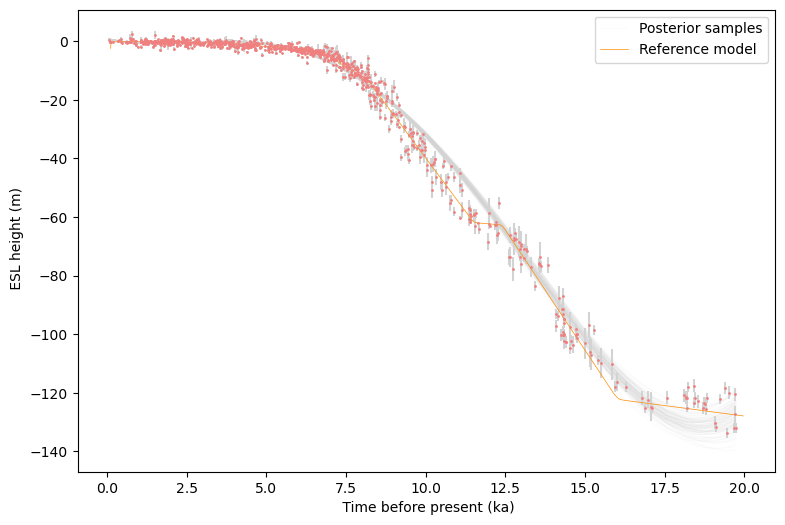

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.5+6.gcc1c01d.dirty
numpy 1.24.4
scipy 1.11.4
matplotlib 3.8.2
emcee 3.1.4
arviz 0.17.0
